In [1]:
import os
import math
import numpy as np
import pandas as pd
from ast import literal_eval
import itertools
import arviz as az
import scipy.stats as st
import seaborn as sns
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
pd.options.mode.chained_assignment = None  # default='warn'

Note that I used pymc3... they've already released pymc4 (just pmyc now). The main difference is in how pm.sample returns the inference data. In my case it's a MultiTrace object and that drives how I call the posterior.

# Data

In [2]:
data = pd.read_csv("data/soc_data_iv.csv")

In [3]:
np.mean(data[data.done == True].time_played), np.std(data[data.done == True].time_played)

(18.54107029051394, 2.7537963271560457)

In [4]:
data.columns

Index(['ID', 'level', 'trial', 'time_played', 'N_attempt', 'done',
       'expectancy', 'SoC', 'crashed', 'N_drift', 'N_prior_crashs',
       'SoC_last_trial', 'trials_since_last_crash', 'crashed_in_last_trial',
       'consecutive_crash_success', 'N_consecutive_crash_success',
       'Neuroticism', 'Extraversion', 'Openness', 'Conscientiousness',
       'Agreeableness', 'Neuroticism_norm', 'Extraversion_norm',
       'Openness_norm', 'Conscientiousness_norm', 'Agreeableness_norm'],
      dtype='object')

In [5]:
# annotate the data to make it more concise
df = data.dropna(subset=["ID", "expectancy", "N_drift", "SoC", "SoC_last_trial", "crashed", "crashed_in_last_trial", "N_consecutive_crash_success"]).copy()

# encode IDs
df["ID_idx"] = pd.Categorical(df["ID"]).codes
n_participants = df["ID_idx"].nunique()

# Bayesian updating process

- we will treat SoC as normally distributed posterior.
- we will split the data by participant ID.
- for every row within the participant data we will model the Bayesian updating process.
 <br />

- we will assess the weighting of the likelihood assuming the prior weight is =1. This will tell us whether individual participants relied more on their prior or their inferred performance when rating their Sense of Control (SoC)

But to find out the difference in weighting of prior and likelihood, we first have to define prior and likelihood, that is specify what constitute them. For this, we can refer to our final selected linear mixed models.

$prior \approx N_{(crash-success)} + SoC_{t-1}$

$likelihood \approx N_{Drift} + crashed_{(0,1)} + crashed_{t-1;0,1} + N_{(crash-success)}$

We will try to approach this prior and likelihood form but start simple. Especially the likelihood may be too complex to be learned, because we're trying to implement a dynamic likelihood weighting (the weight of the likelihood in the updating process changes over trials).

## Hierarchical Bayesian Model with dynamic likelihood weighting

Let the log weight evolve linearly across trials:

$log(w){_i,_t} = \alpha{_i} + \beta{_i} * trial{_i,_t}$

Here: *expectancy* as prior & *N_drift* (performance) as likelihood

In [6]:
with pm.Model() as simple_model:
    
    # indexing
    trial_idxs = pm.Data("trial_idxs", df["trial"].values)
    participant_idxs = pm.Data("participant_idxs", df["ID_idx"].values)

    # inputs for prior and likelihood
    expectancy = pm.Data("expectancy", df["expectancy"].values)
    N_drift = pm.Data("N_drift", df["N_drift"].values)

    # hyperpriors
    mu_alpha = pm.Normal("mu_alpha", 0, 1)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 1)
    
    mu_beta = pm.Normal("mu_beta", 0, 1)
    sigma_beta = pm.HalfNormal("sigma_beta", 1)

    # per-participant parameters
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=n_participants)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=n_participants)

    # dynamic likelihood weight (log scale to keep positive)
    log_w = alpha[participant_idxs] + beta[participant_idxs] * trial_idxs
    w = pm.Deterministic("w", pm.math.exp(log_w))

    # weighted average of prior and likelihood
    mu_soc = (expectancy + w * N_drift) / (1 + w)

    # observation model
    sigma = pm.HalfNormal("sigma", 0.1)
    SoC_obs = pm.Normal("SoC_obs", mu=mu_soc, sigma=sigma, observed=df["SoC"].values)

    # predictions
    SoC_pred = pm.Deterministic("SoC_pred", mu_soc)

    # sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.95)


/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_10489/1440963533.py:36: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.


Now: split up the prior into *SoC_last_trial* & *N_consecutive_crash_success* (the variables that explained expectancy in our model selection)

In [7]:
with pm.Model() as expanded_prior_model:
    
    # indexing
    trial_idxs = pm.Data("trial_idxs", df["trial"].values)
    participant_idxs = pm.Data("participant_idxs", df["ID_idx"].values)

    # inputs for prior and likelihood
    SoC_last = pm.Data("SoC_last_trial", df["SoC_last_trial"].values)
    N_crash_success = pm.Data("N_consecutive_crash_success", df["N_consecutive_crash_success"].values)
    N_drift = pm.Data("N_drift", df["N_drift"].values)

    # hyperpriors for prior weights (SoC_last and crash/success history)
    mu_alpha = pm.Normal("mu_alpha", 0, 1, shape=2)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 1, shape=2)

    # participant-level coefficients for prior
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=(n_participants, 2))

    # compute prior: linear combo of predictors
    prior = (
        alpha[participant_idxs, 0] * SoC_last +
        alpha[participant_idxs, 1] * N_crash_success
    )

    # hyperpriors for drift weighting
    mu_beta = pm.Normal("mu_beta", 0, 1)
    sigma_beta = pm.HalfNormal("sigma_beta", 1)

    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=n_participants)

    # dynamic likelihood weight (log scale)
    log_w = beta[participant_idxs] * trial_idxs
    w = pm.Deterministic("w", pm.math.exp(log_w))

    # posterior expectation (weighted average of prior and likelihood)
    mu_soc = (prior + w * N_drift) / (1 + w)

    # observation model
    sigma = pm.HalfNormal("sigma", 0.1)
    SoC_obs = pm.Normal("SoC_obs", mu=mu_soc, sigma=sigma, observed=df["SoC"].values)

    # predictions
    SoC_pred = pm.Deterministic("SoC_pred", mu_soc)

    # sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.95)


/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_10489/1673918473.py:46: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, sigma_beta, mu_beta, alpha, sigma_alpha, mu_alpha]


/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3462 seconds.
The acceptance probability does not match the target. It is 0.9978966017114466, but should be close to 0.95. Try t

## Individual (per participant) plots

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_10489/3983316057.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


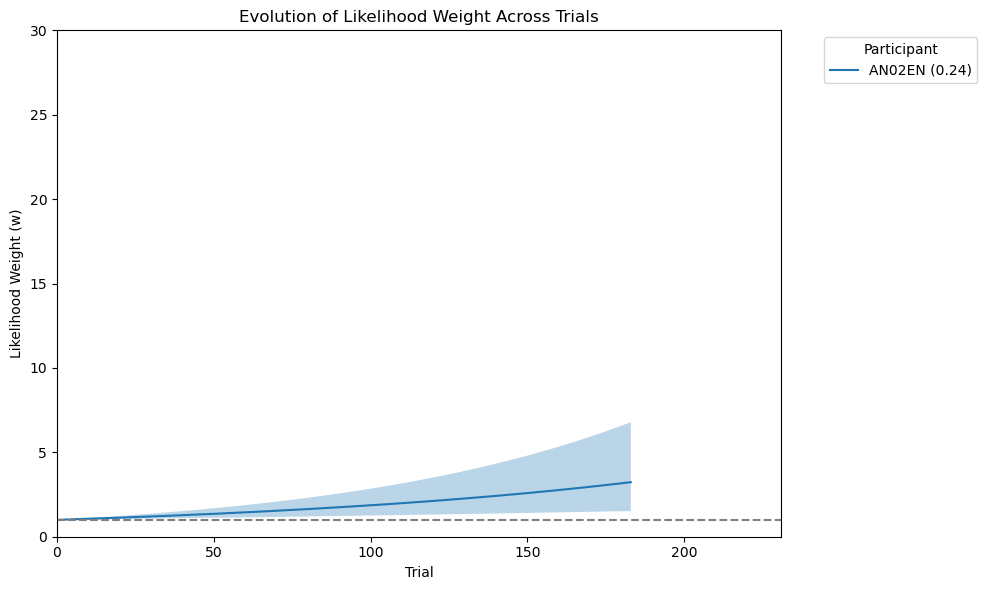

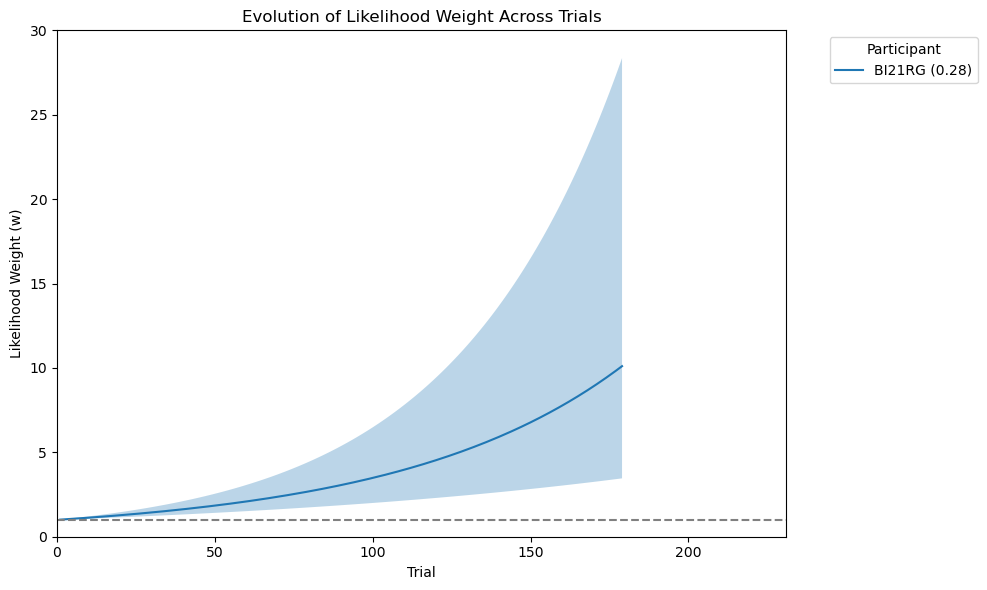

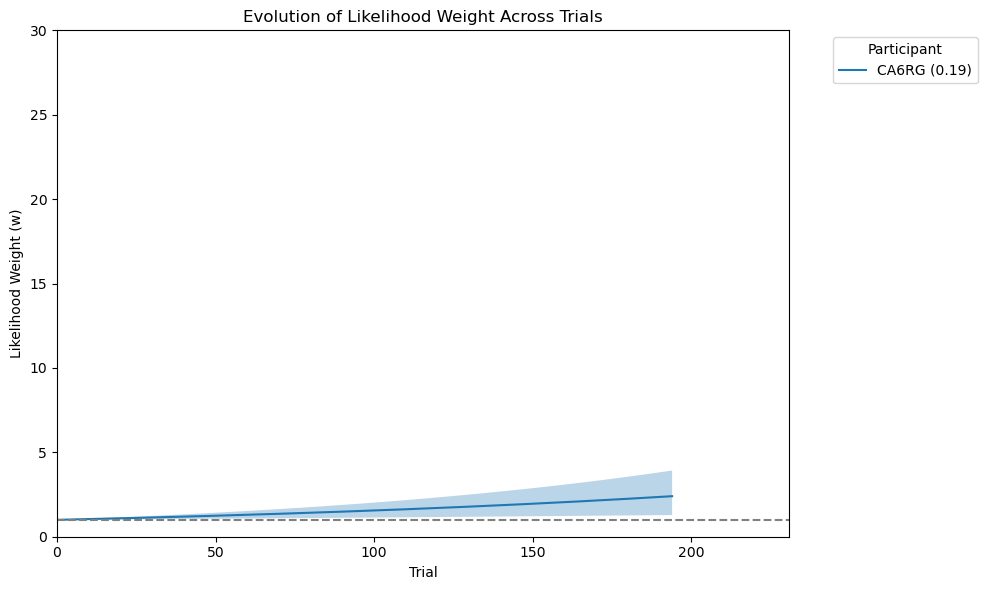

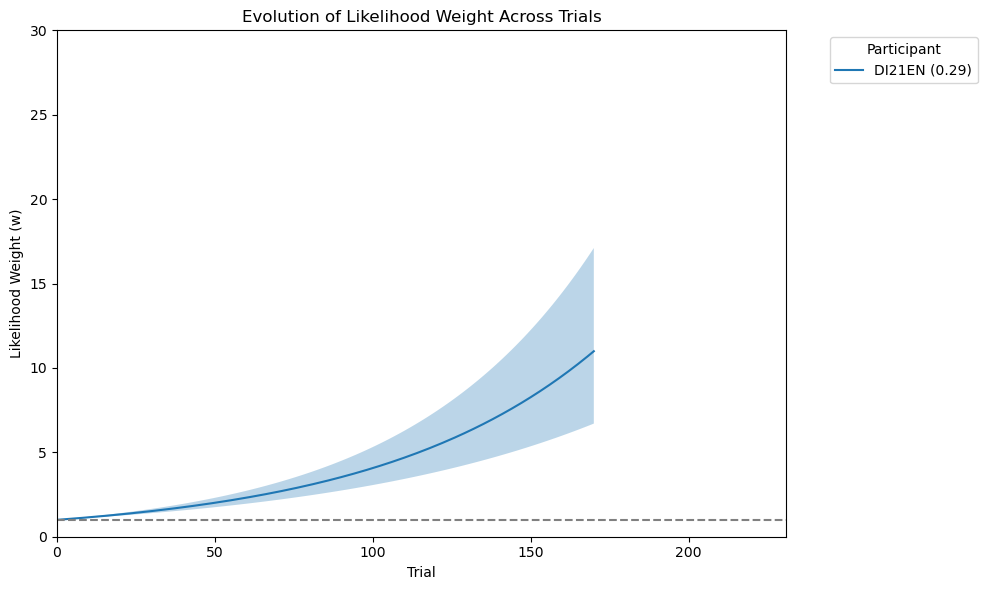

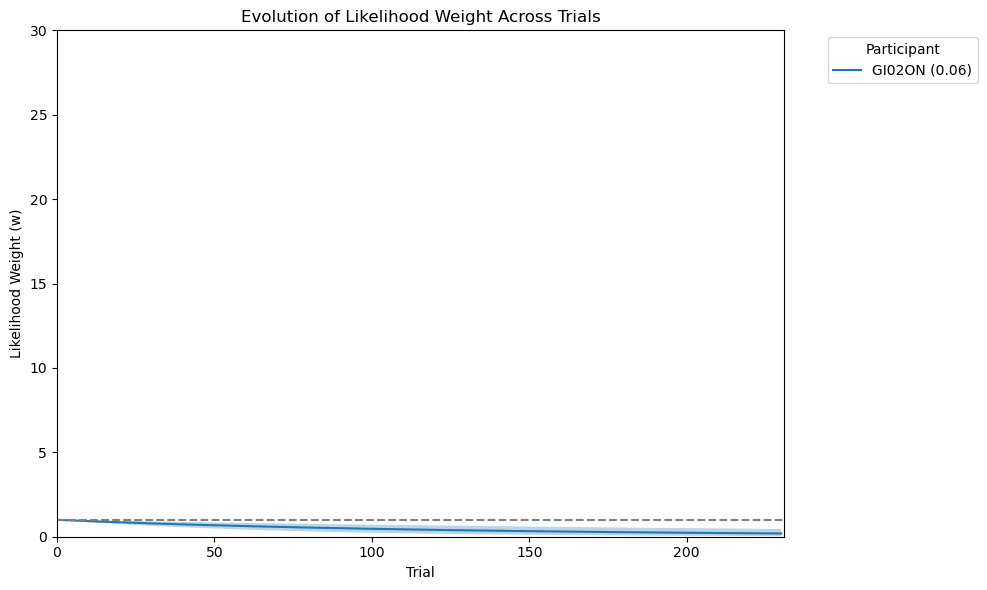

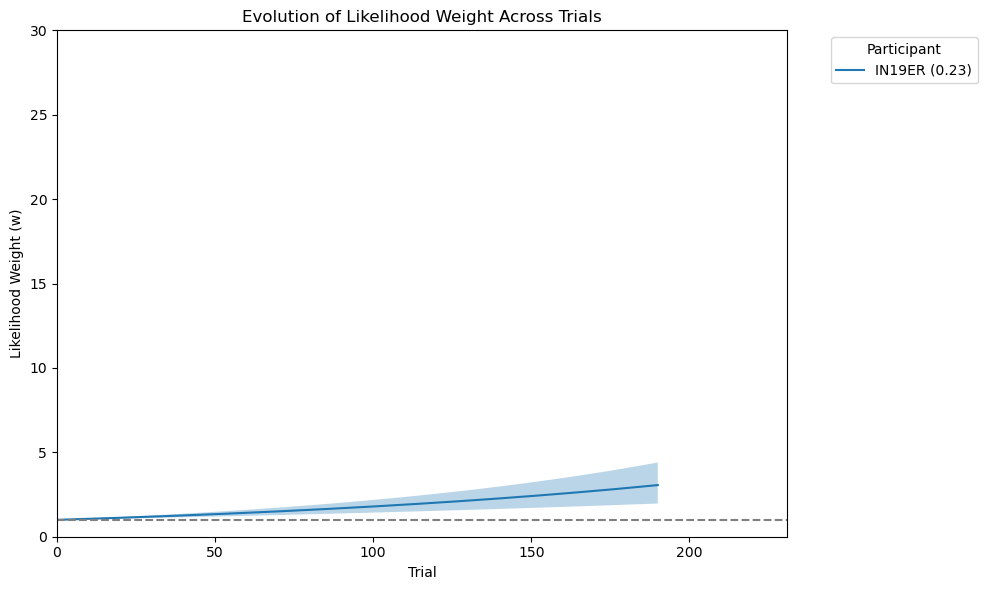

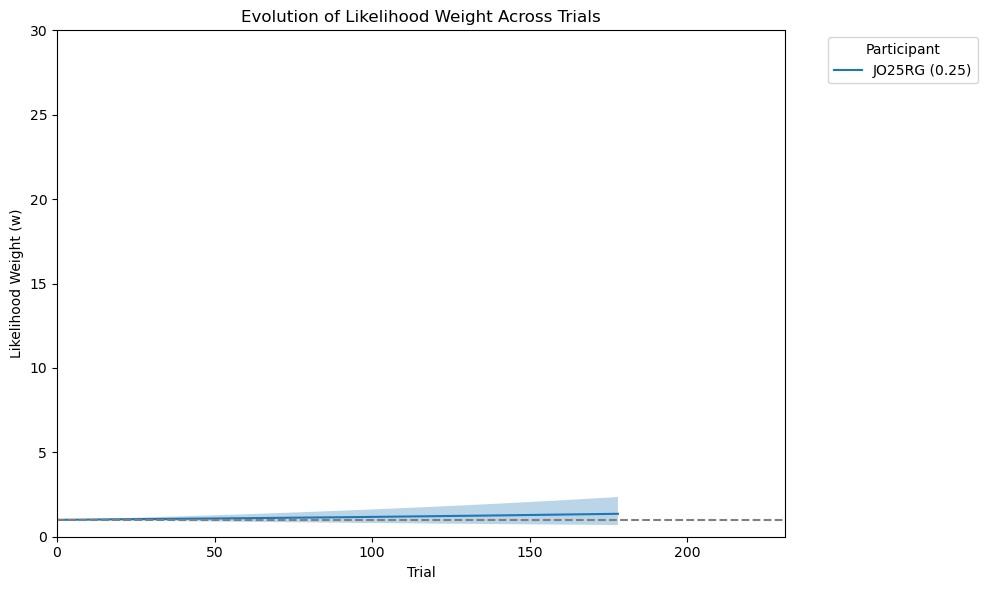

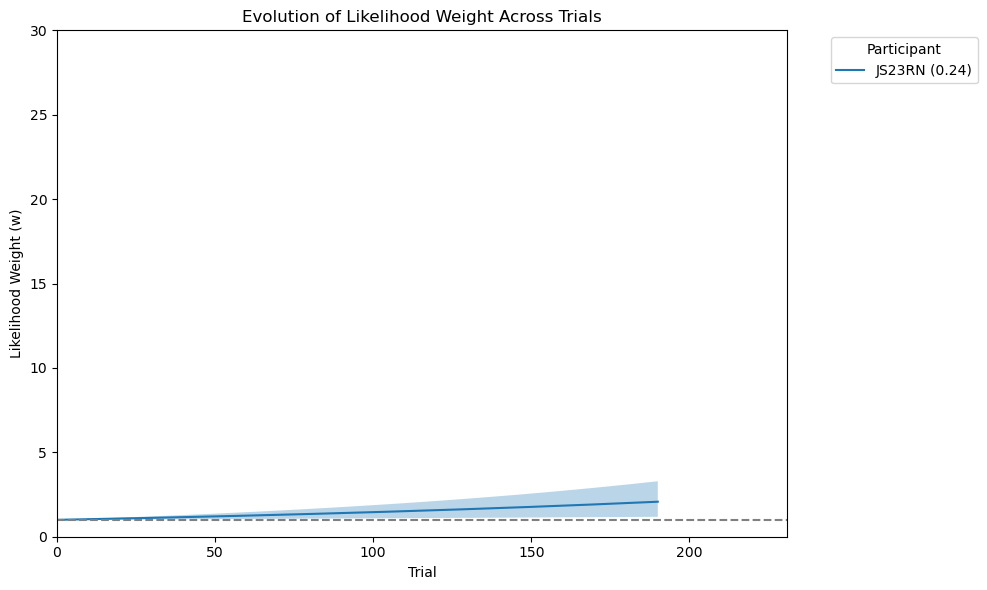

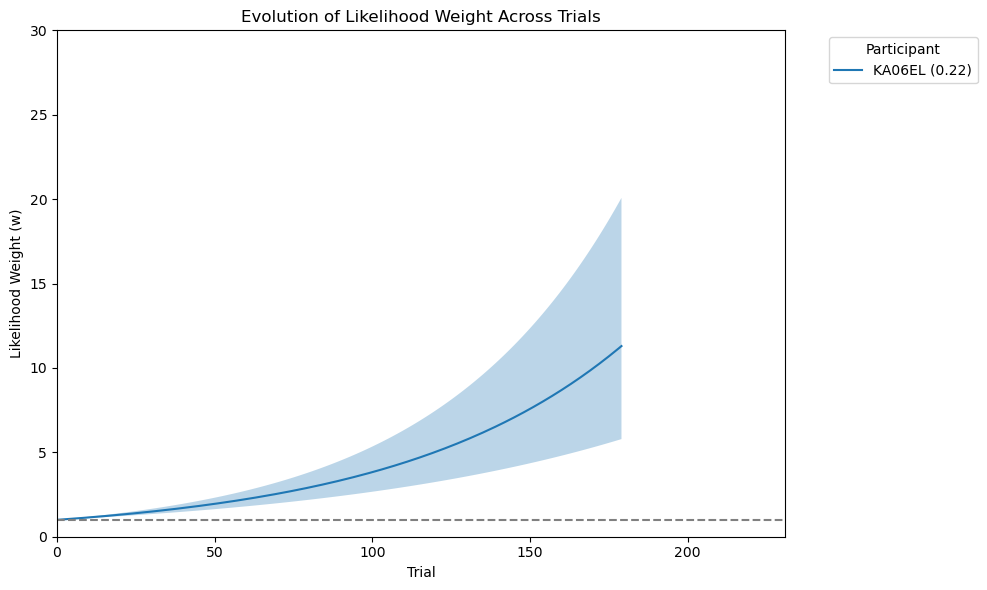

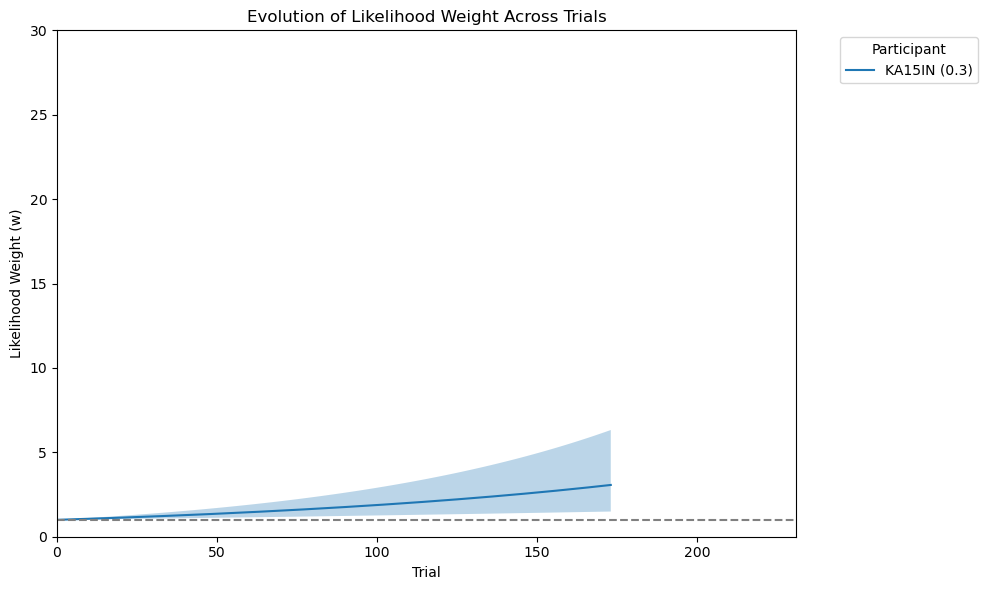

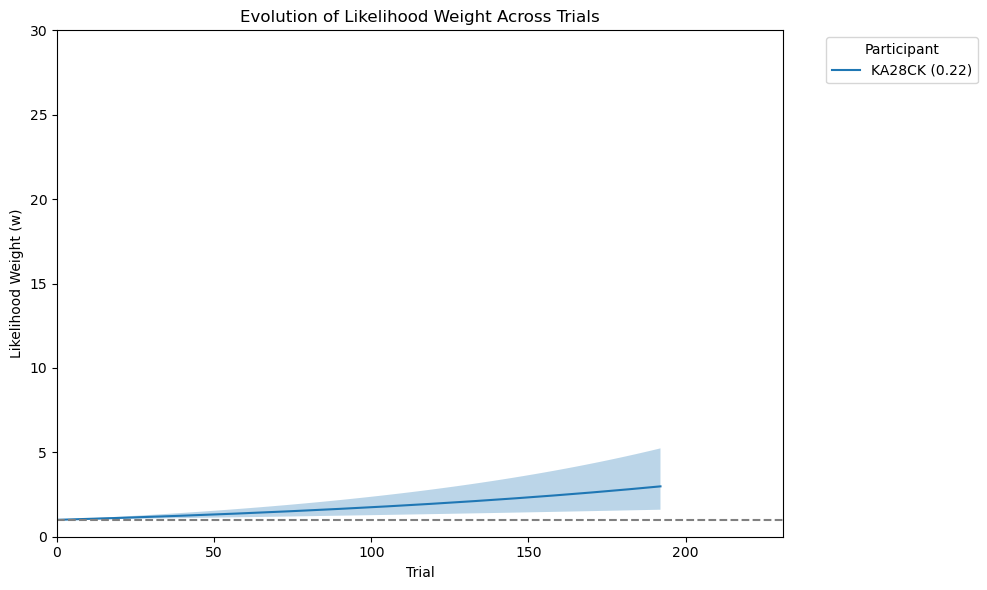

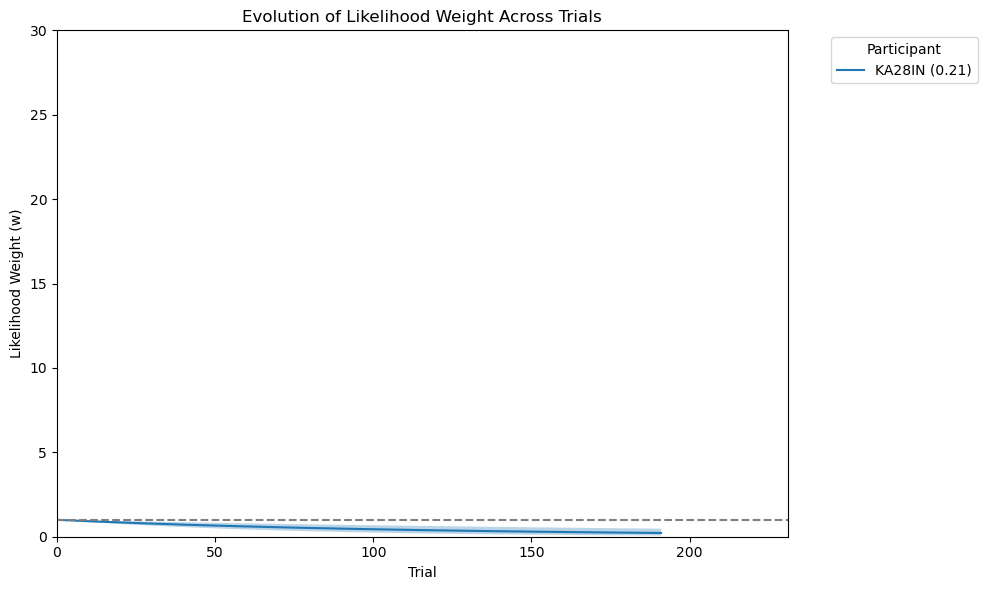

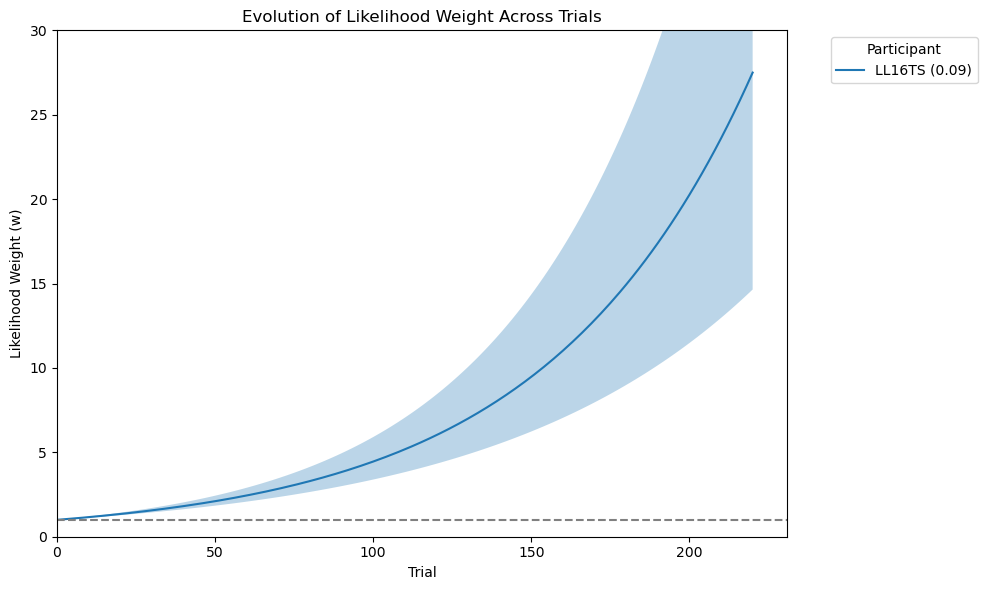

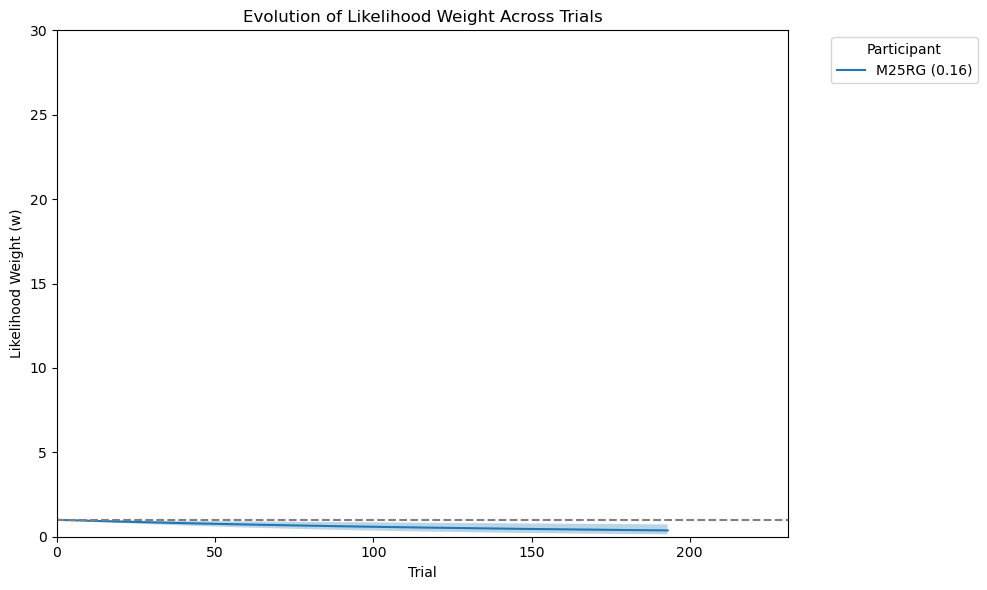

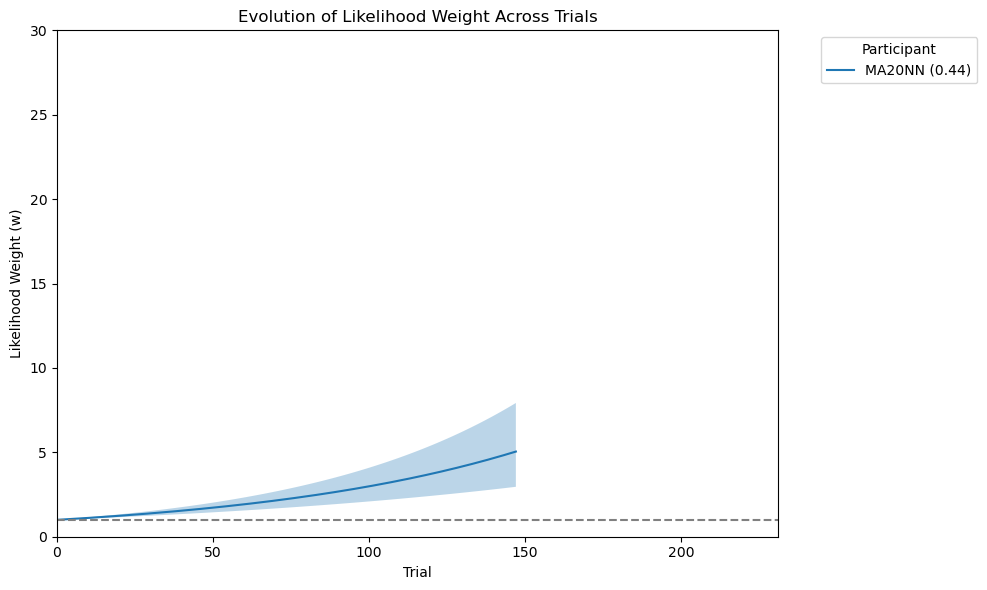

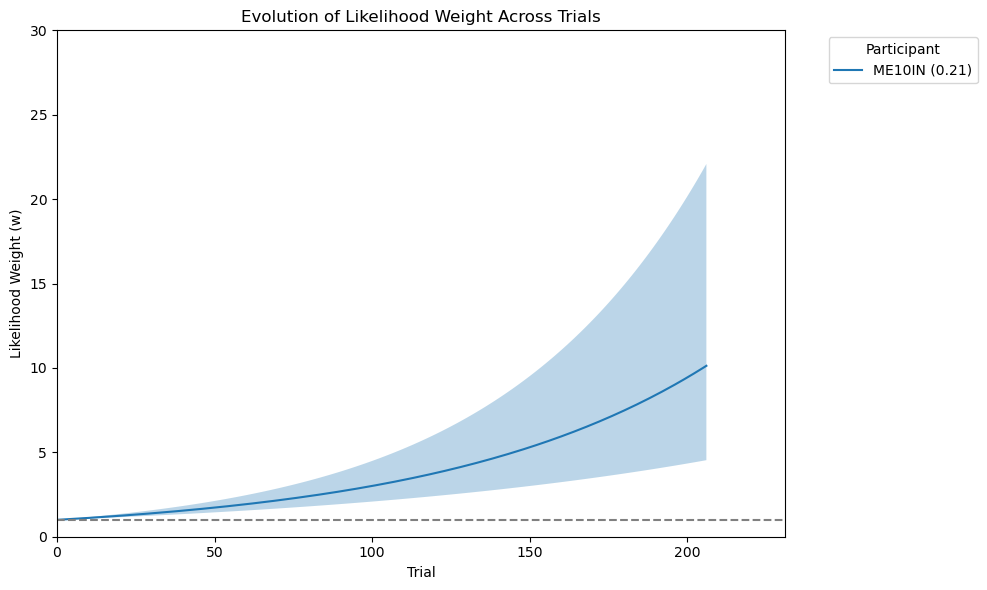

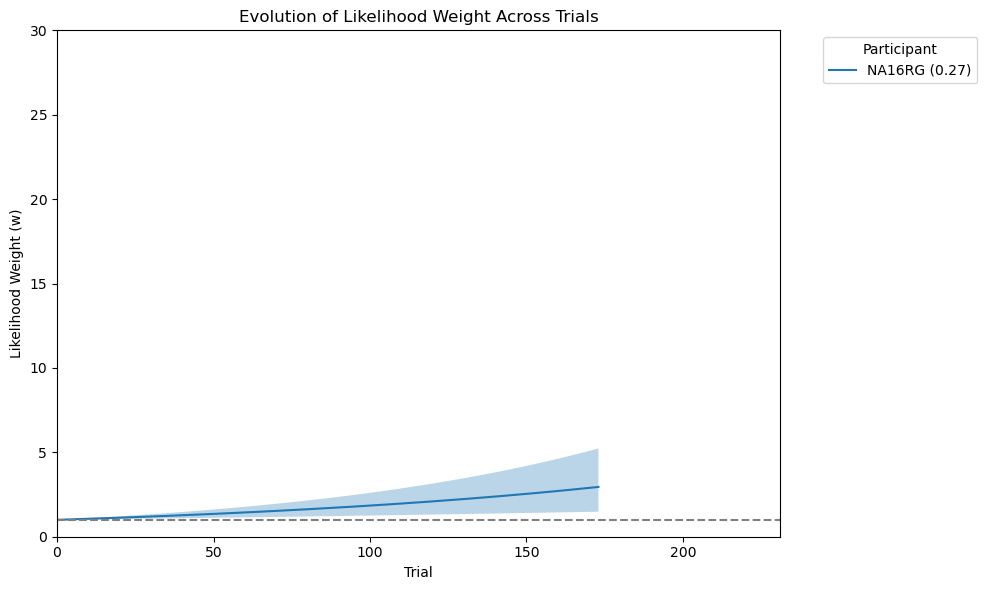

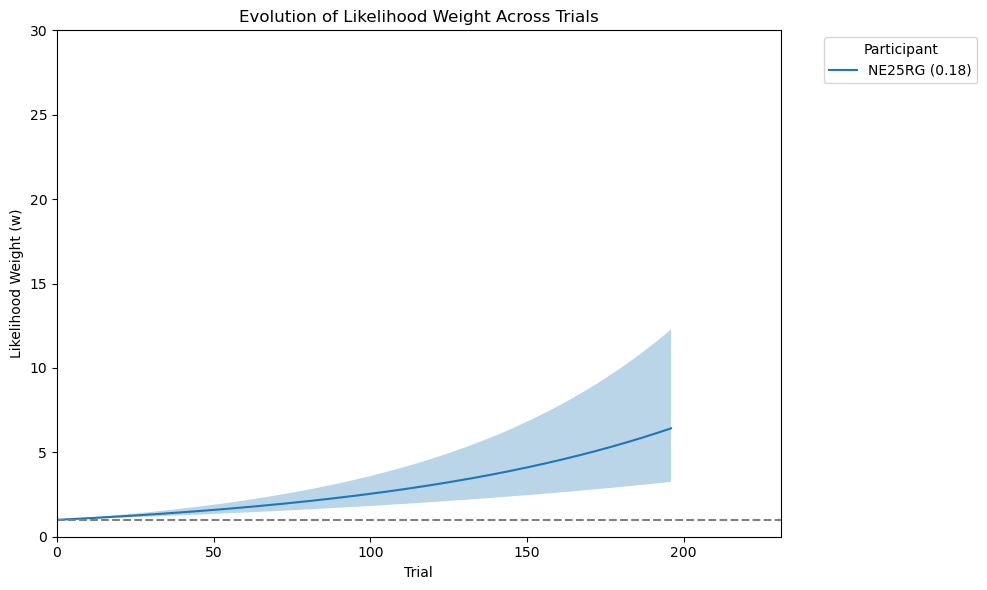

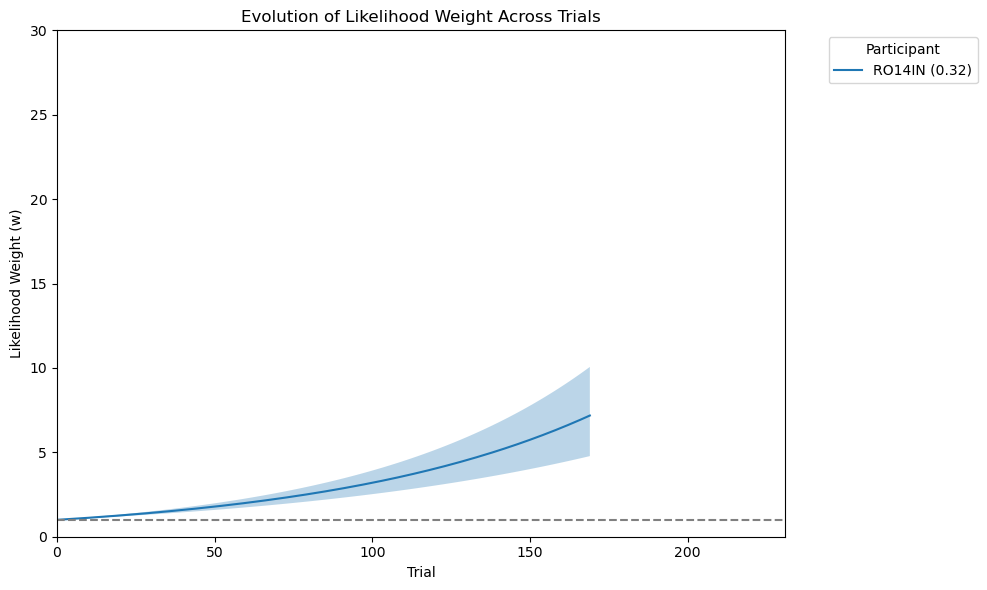

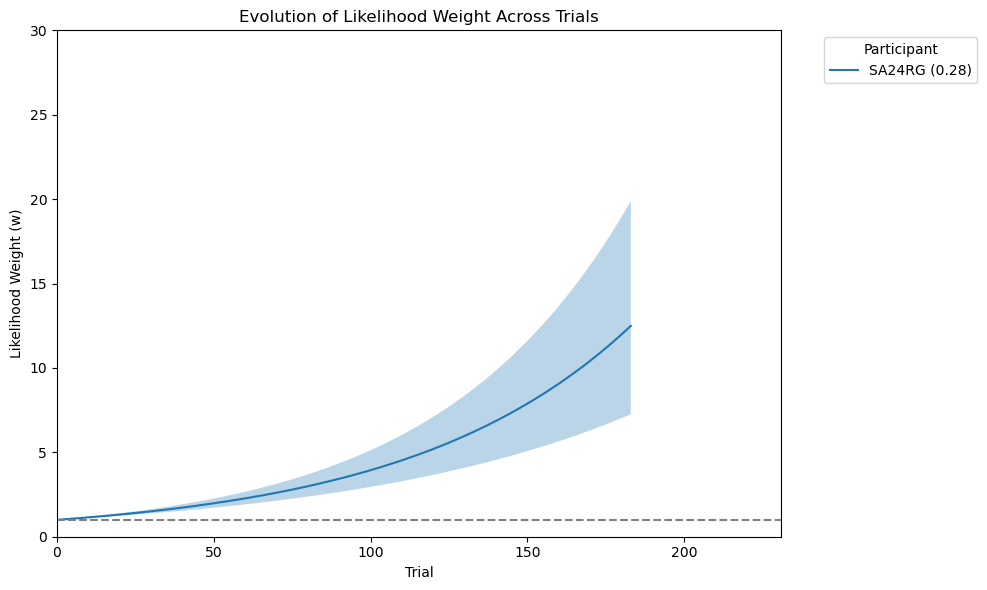

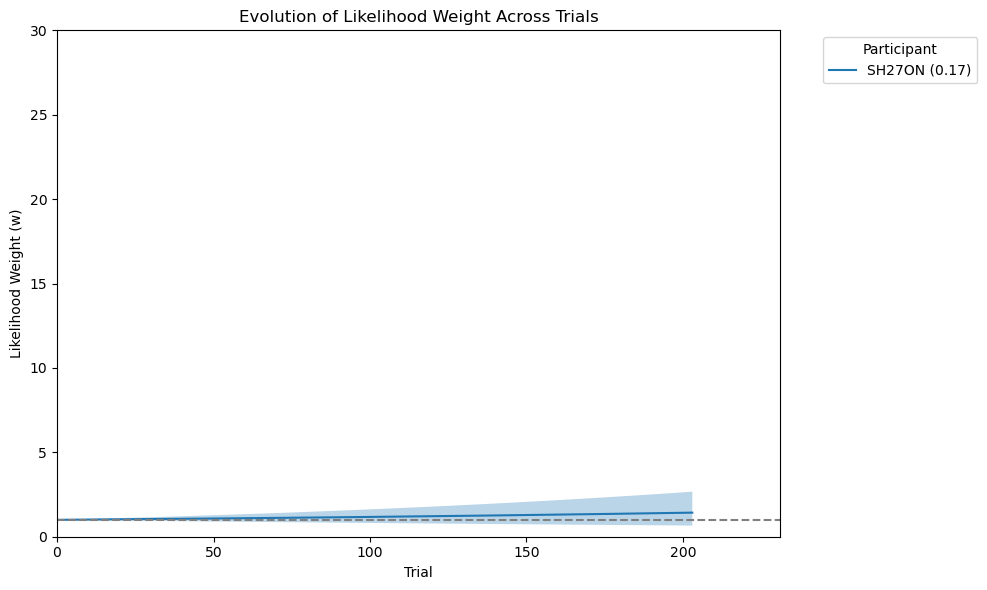

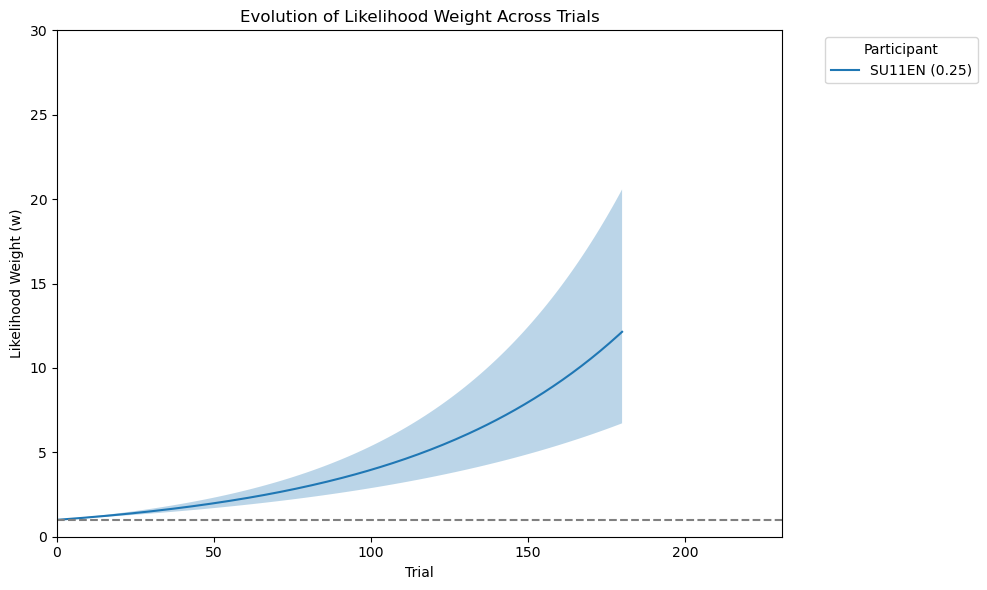

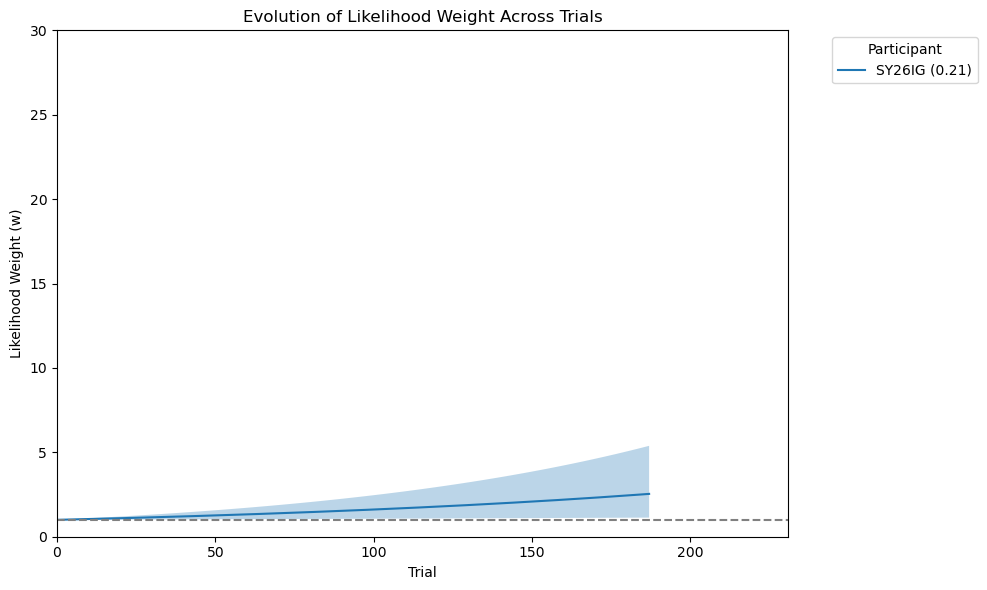

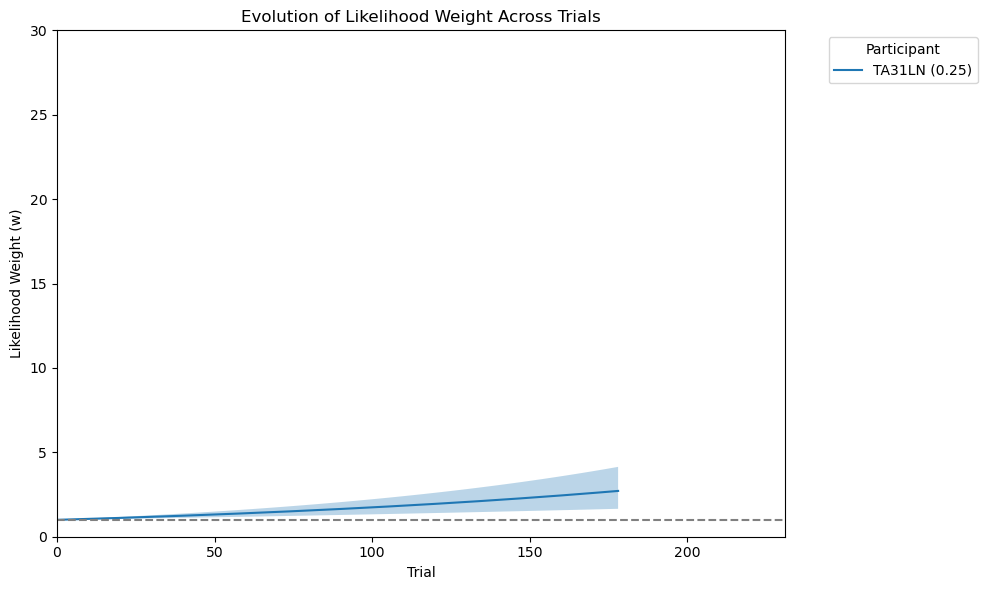

In [35]:
# extract the samples for 'w' from the trace
w_samples = trace.get_values("w", combine=True)  # shape: (n_total_samples, n_observations)

# compute posterior mean for each observation
w_mean = w_samples.mean(axis=0)

# get number of participants
n_participants = trace["alpha"].shape[1]

for i in range(n_participants):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    participant_mask = df["ID_idx"] == i
    trial_nums = df["trial"].values[participant_mask]
    
    # extract posterior samples for participant's trials
    w_participant_samples = w_samples[:, participant_mask]  # shape: (n_samples, n_trials_for_this_pid)
    
    w_vals = w_mean[participant_mask]
    
    # compute HDI
    w_hpd_low = np.percentile(w_participant_samples, 2.5, axis=0)
    w_hpd_high = np.percentile(w_participant_samples, 97.5, axis=0)
    
    # trial range for individual participant
    max_trial = df[df["ID_idx"] == i]["trial"].max()
    trial_range = np.arange(0, max_trial + 1)
    
    # get ID and success rate
    identify = df[df["ID_idx"] == i].ID.iloc[0]
    rate = df[df["ID_idx"] == i].crashed.sum() / max_trial
    
    # plotting
    ax.plot(trial_nums, w_vals, label=f"{identify} ({round(1-rate,2)})")
    ax.fill_between(trial_nums, w_hpd_low, w_hpd_high, alpha=0.3)

    # reference line for prior weight
    plt.axhline(1.0, color='gray', linestyle='--')  # , label="Prior weight = 1"    

    ax.set_ylim(0, 30)
    ax.set_xlim(0, 231)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Likelihood Weight (w)")
    ax.set_title("Evolution of Likelihood Weight Across Trials")
    plt.legend(title="Participant", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    #plt.show()


## Paper plots

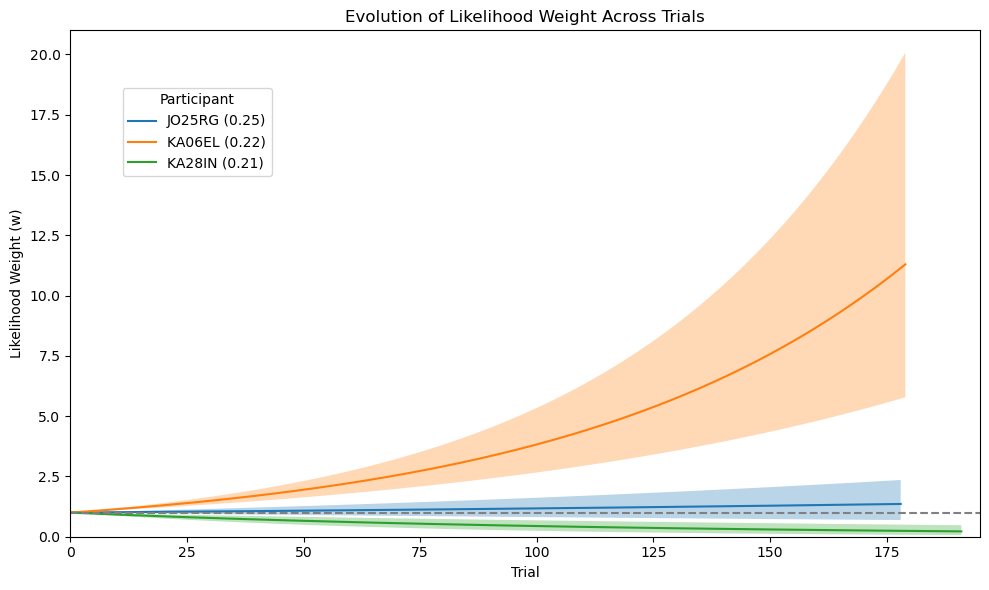

In [62]:
# extract the samples for 'w' from the trace
w_samples = trace.get_values("w", combine=True)  # shape: (n_total_samples, n_observations)

# compute posterior mean for each observation
w_mean = w_samples.mean(axis=0)

# get number of participants
n_participants = trace["alpha"].shape[1]

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_participants):
    
    participant_mask = df["ID_idx"] == i
    trial_nums = df["trial"].values[participant_mask]
    
    # extract posterior samples for participant's trials
    w_participant_samples = w_samples[:, participant_mask]  # shape: (n_samples, n_trials_for_this_pid)
    
    w_vals = w_mean[participant_mask]
    
    # compute HDI
    w_hpd_low = np.percentile(w_participant_samples, 2.5, axis=0)
    w_hpd_high = np.percentile(w_participant_samples, 97.5, axis=0)
    
    # trial range for individual participant
    max_trial = df[df["ID_idx"] == i]["trial"].max()
    trial_range = np.arange(0, max_trial + 1)
    
    # get ID and success rate
    identity = df[df["ID_idx"] == i].ID.iloc[0]
    rate = df[df["ID_idx"] == i].crashed.sum() / max_trial
    
    if identity in ["JO25RG", "KA06EL", "KA28IN"]:  # hand selected
        # plotting
        ax.plot(trial_nums, w_vals, label=f"{identity} ({round(1-rate,2)})")
        ax.fill_between(trial_nums, w_hpd_low, w_hpd_high, alpha=0.3)

# reference line for prior weight
plt.axhline(1.0, color='gray', linestyle='--')  # , label="Prior weight = 1"    

ax.set_ylim(0, 21)
ax.set_xlim(0, 195)
ax.set_xlabel("Trial")
ax.set_ylabel("Likelihood Weight (w)")
ax.set_title("Evolution of Likelihood Weight Across Trials")
plt.legend(title="Participant", bbox_to_anchor=(0.05, 0.9), loc='upper left')
plt.tight_layout()
#plt.show()


## Extremes

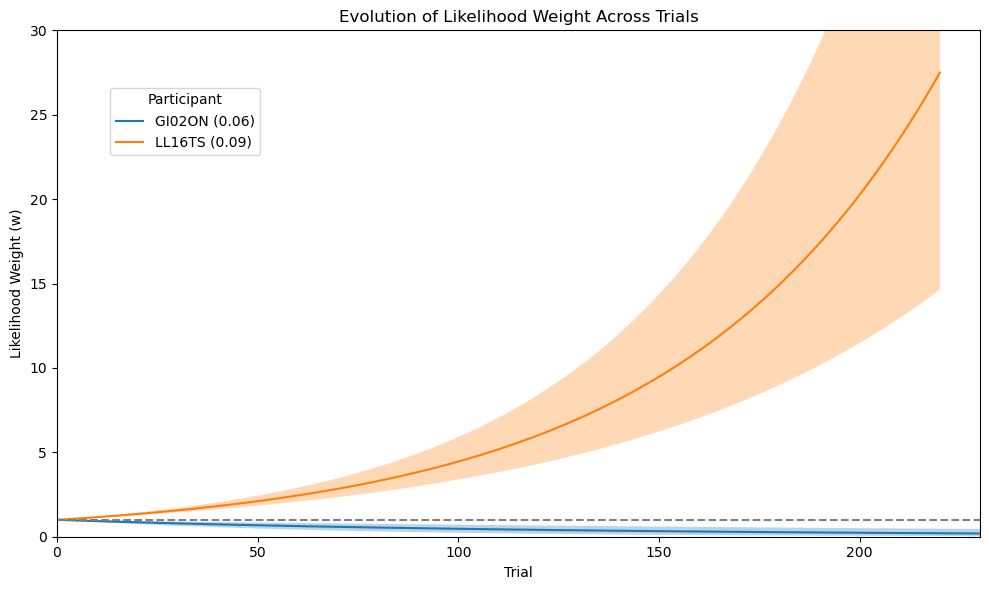

In [45]:
# extract the samples for 'w' from the trace
w_samples = trace.get_values("w", combine=True)  # shape: (n_total_samples, n_observations)

# compute posterior mean for each observation
w_mean = w_samples.mean(axis=0)

# get number of participants
n_participants = trace["alpha"].shape[1]

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_participants):
    
    participant_mask = df["ID_idx"] == i
    trial_nums = df["trial"].values[participant_mask]
    
    # extract posterior samples for participant's trials
    w_participant_samples = w_samples[:, participant_mask]  # shape: (n_samples, n_trials_for_this_pid)
    
    w_vals = w_mean[participant_mask]
    
    # compute HDI
    w_hpd_low = np.percentile(w_participant_samples, 2.5, axis=0)
    w_hpd_high = np.percentile(w_participant_samples, 97.5, axis=0)
    
    # trial range for individual participant
    max_trial = df[df["ID_idx"] == i]["trial"].max()
    trial_range = np.arange(0, max_trial + 1)
    
    # get ID and success rate
    identity = df[df["ID_idx"] == i].ID.iloc[0]
    rate = df[df["ID_idx"] == i].crashed.sum() / max_trial
    
    if identity in ["LL16TS", "GI02ON"]:  # hand selected
        # plotting
        ax.plot(trial_nums, w_vals, label=f"{identity} ({round(1-rate,2)})")
        ax.fill_between(trial_nums, w_hpd_low, w_hpd_high, alpha=0.3)

# reference line for prior weight
plt.axhline(1.0, color='gray', linestyle='--')  # , label="Prior weight = 1"    

ax.set_ylim(0, 30)
ax.set_xlim(0, 230)
ax.set_xlabel("Trial")
ax.set_ylabel("Likelihood Weight (w)")
ax.set_title("Evolution of Likelihood Weight Across Trials")
plt.legend(title="Participant", bbox_to_anchor=(0.05, 0.9), loc='upper left')
plt.tight_layout()
#plt.show()


# Validation (fit of model and human data)

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


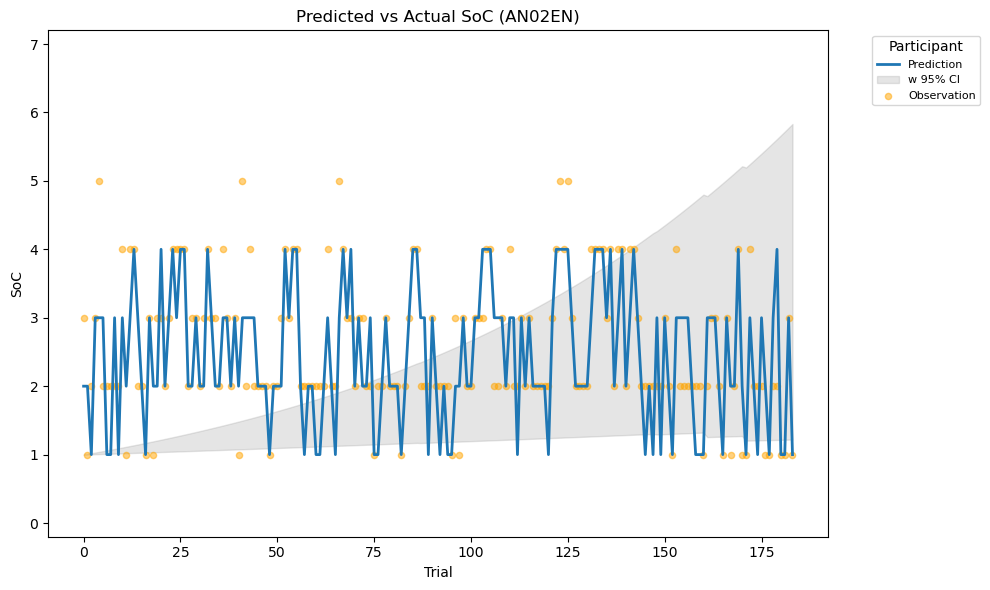

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


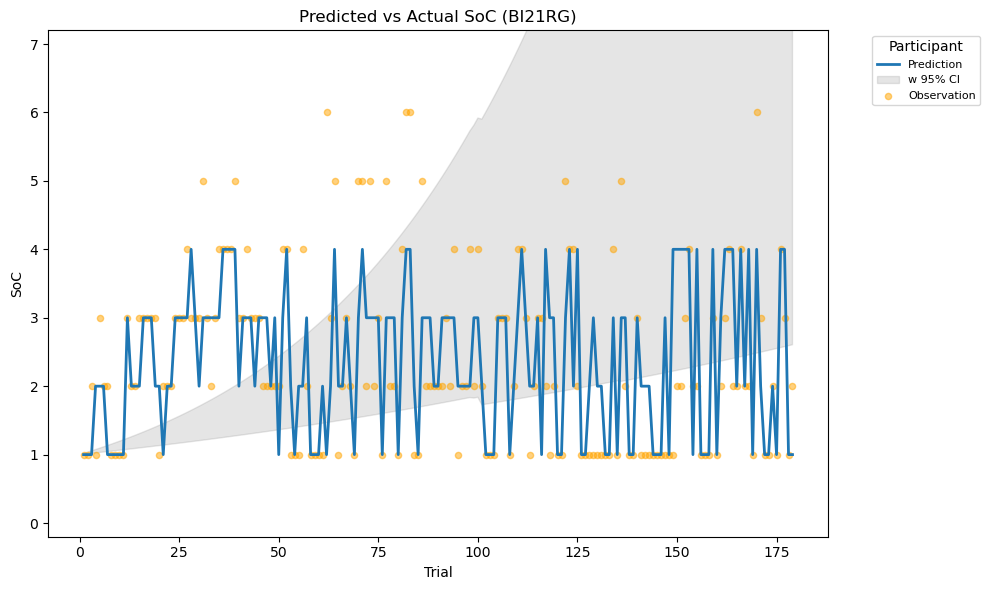

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


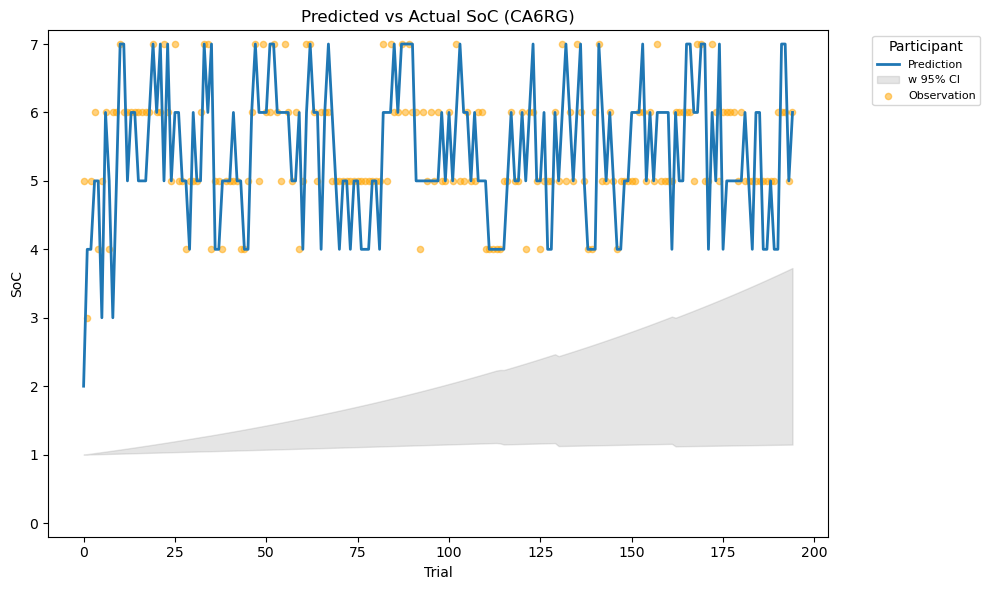

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


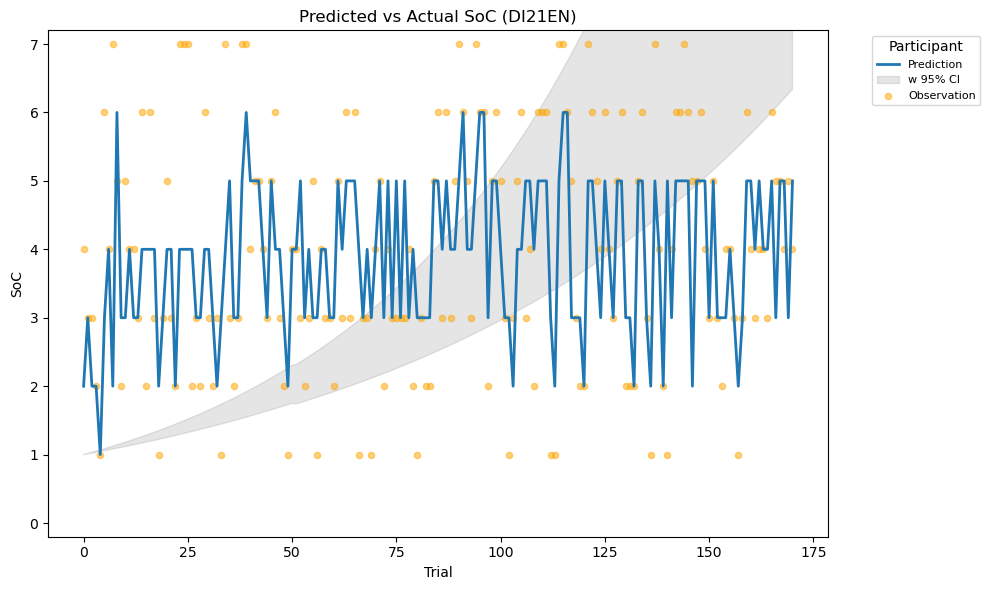

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


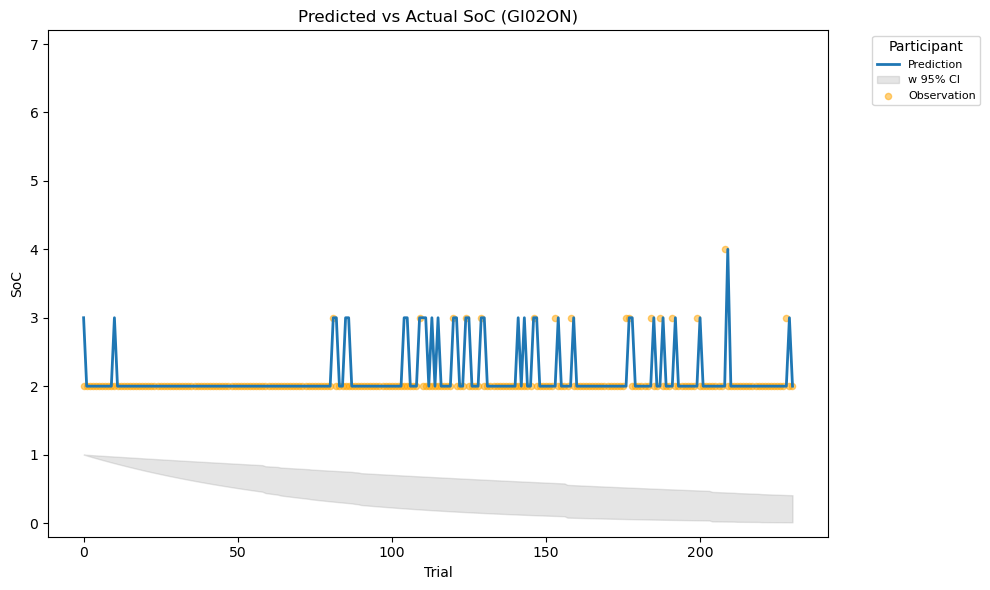

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


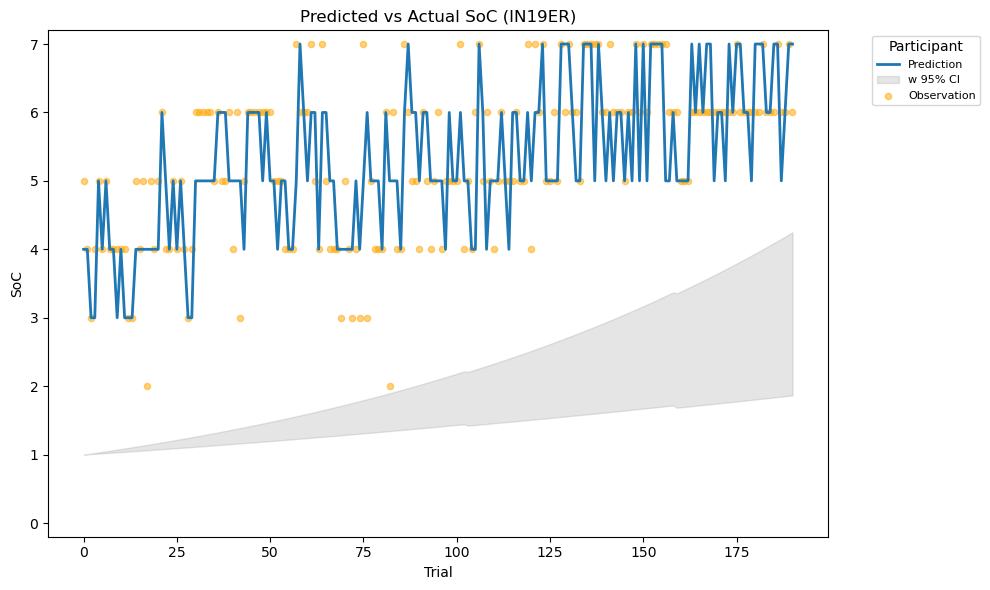

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


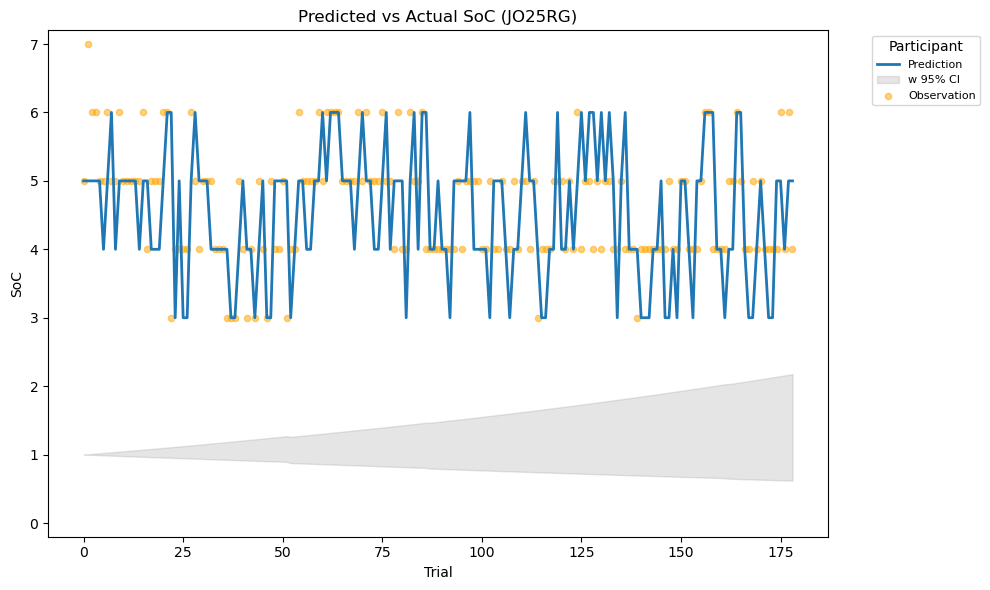

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


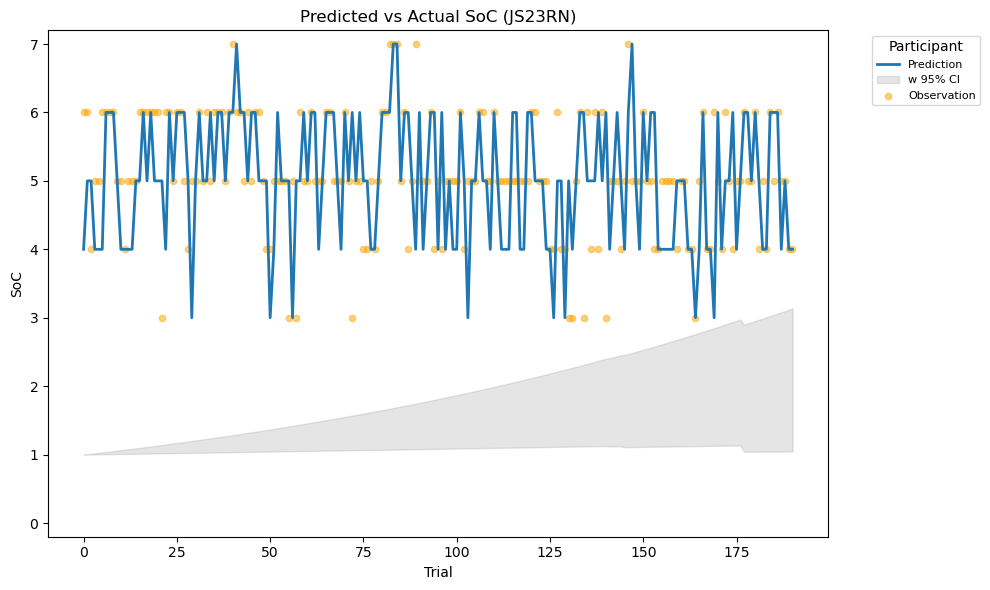

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


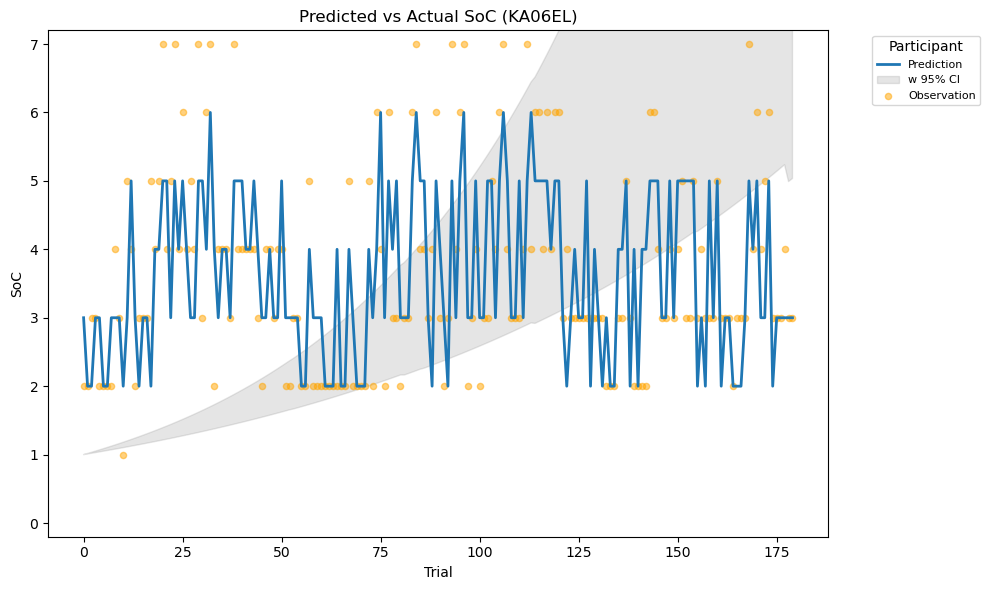

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


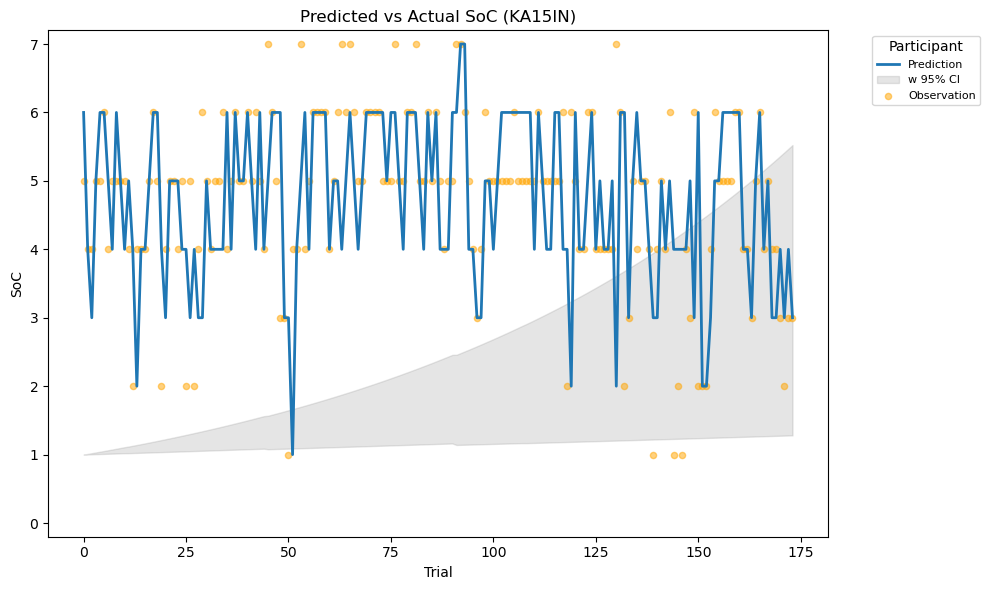

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


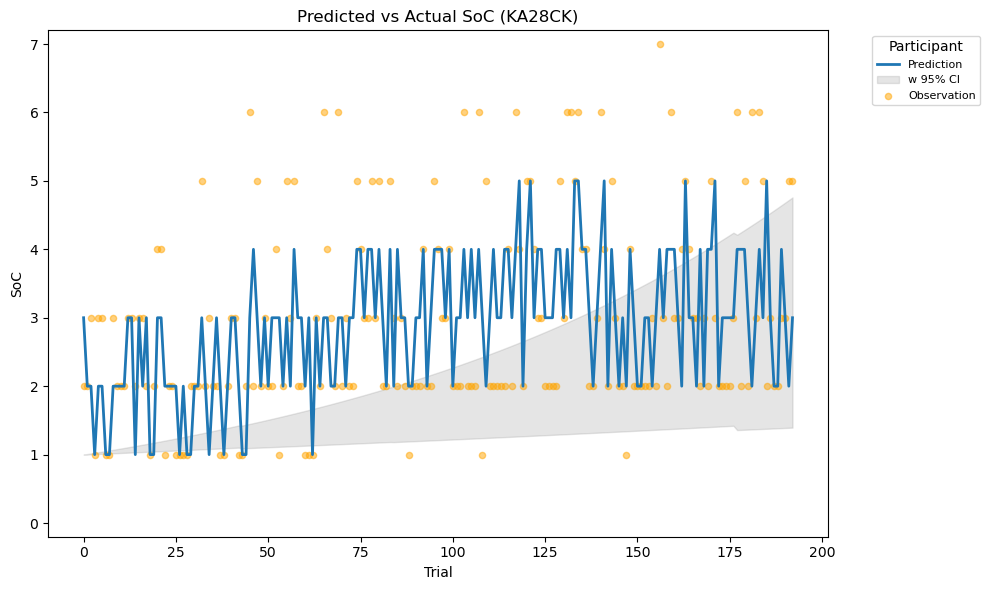

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


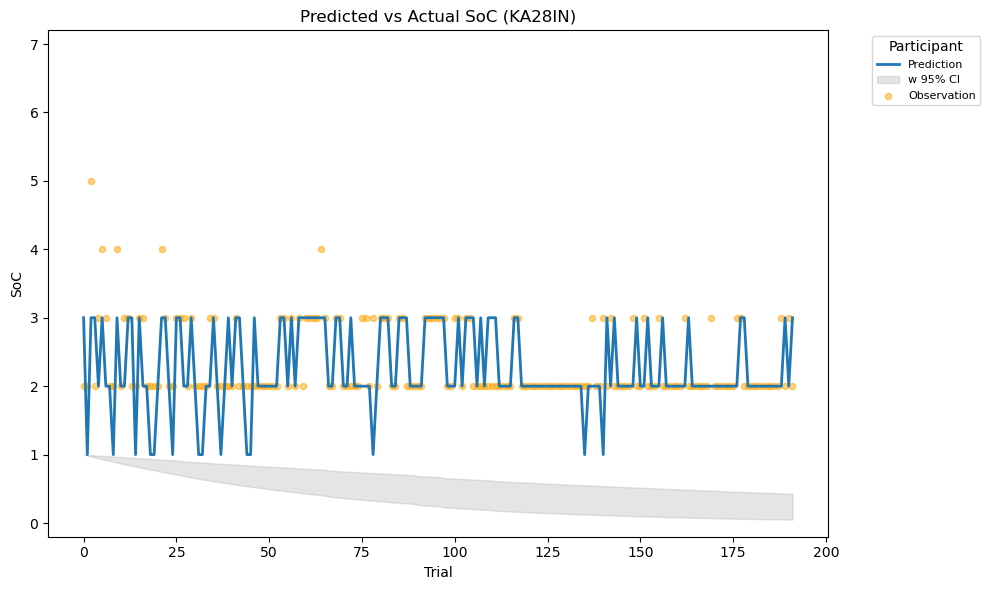

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


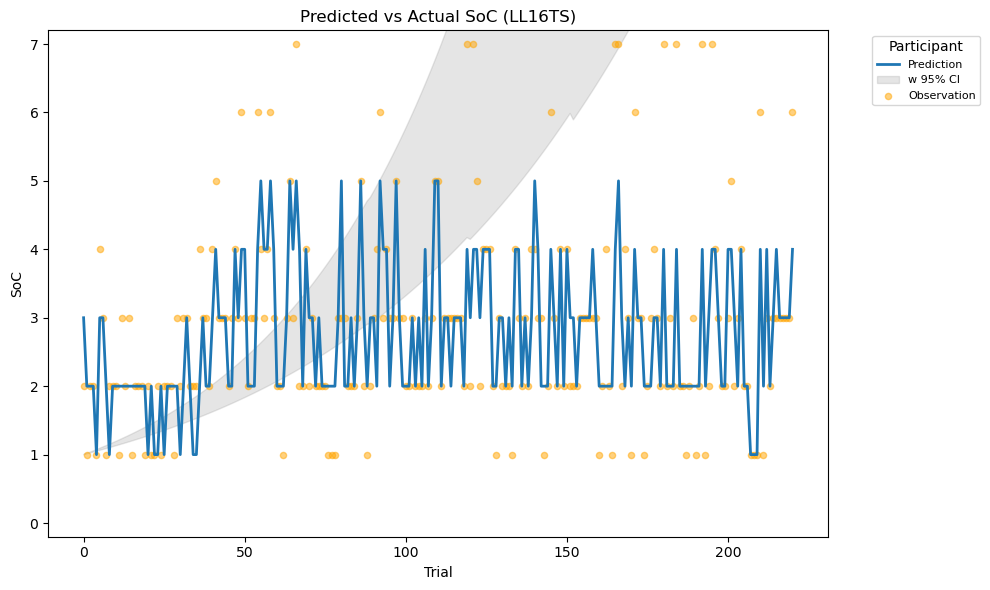

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


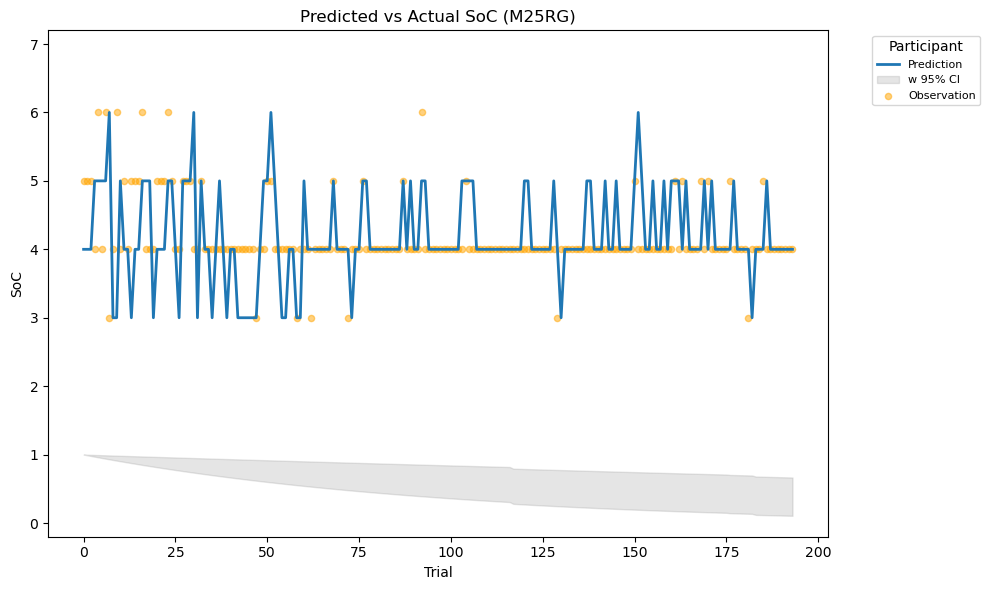

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


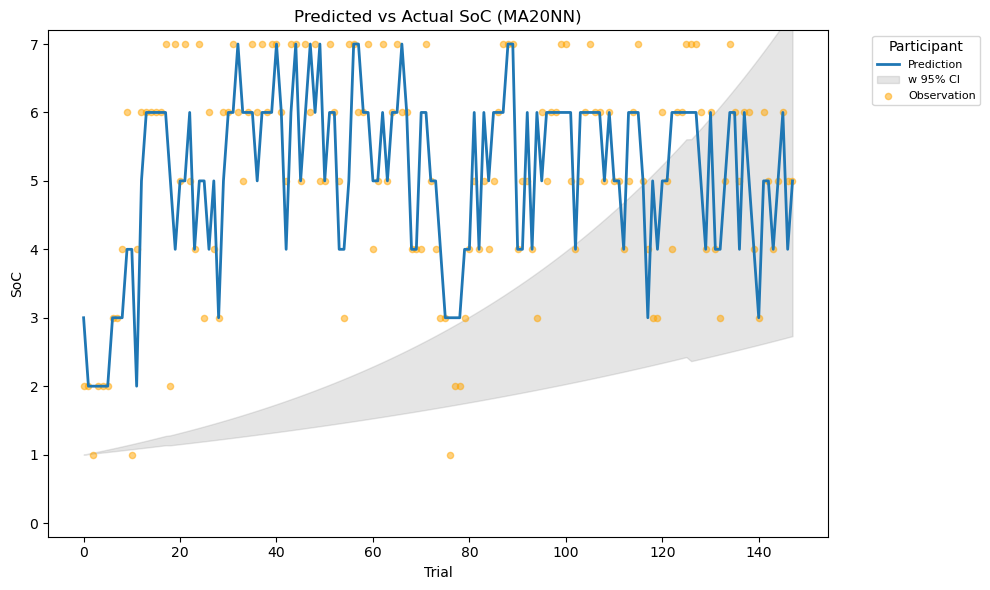

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


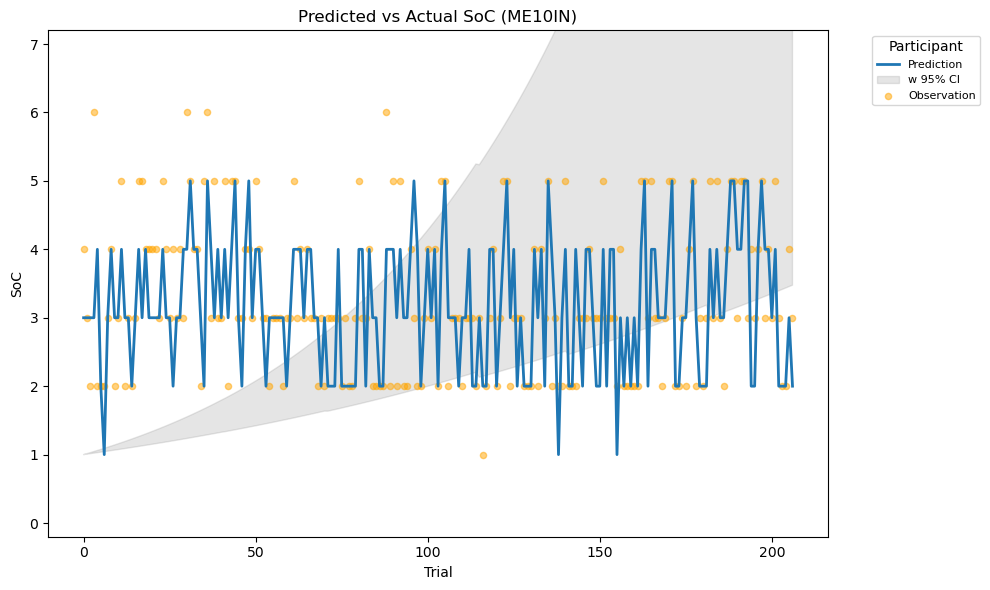

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


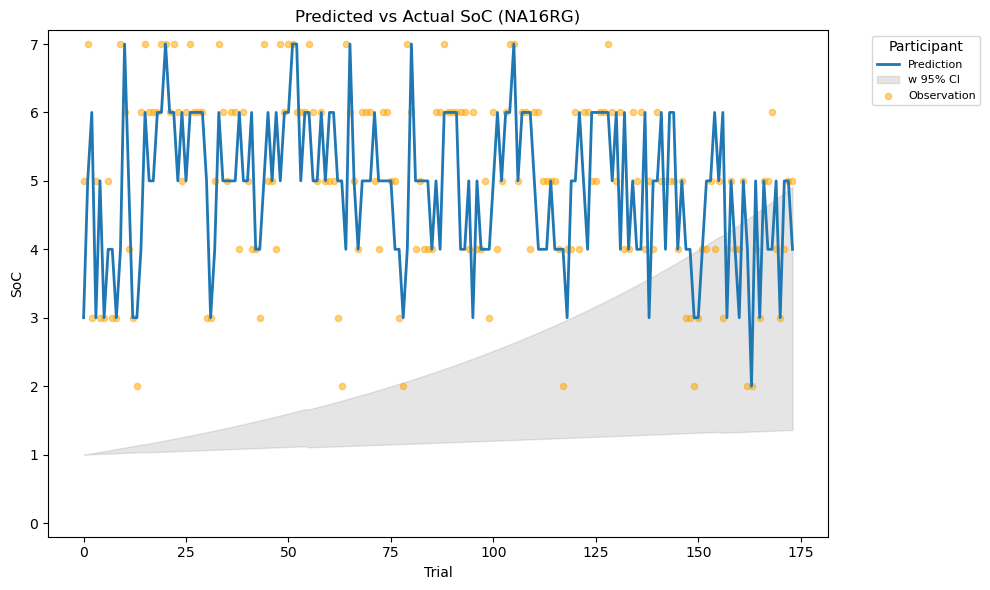

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


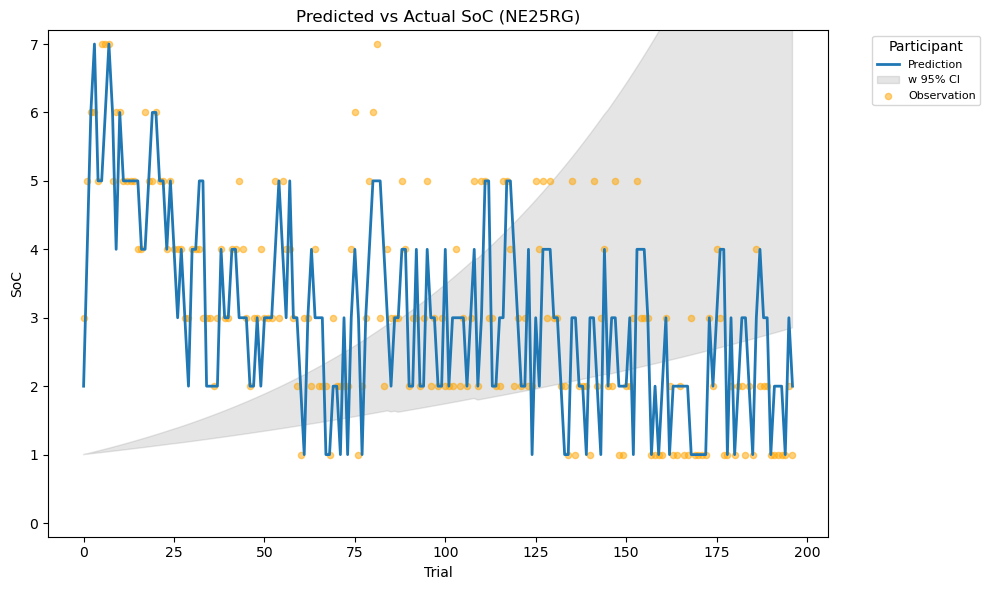

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


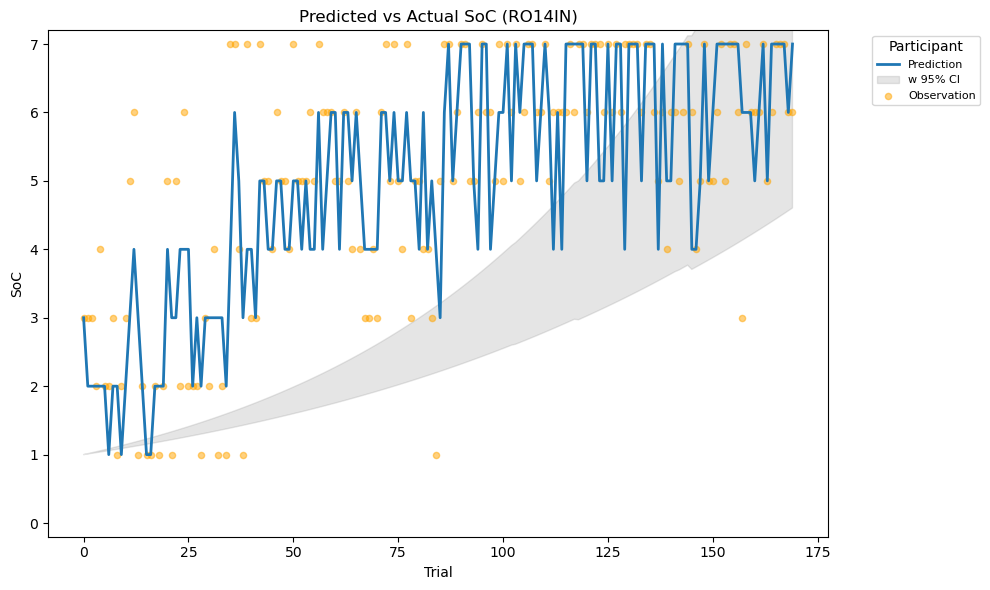

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


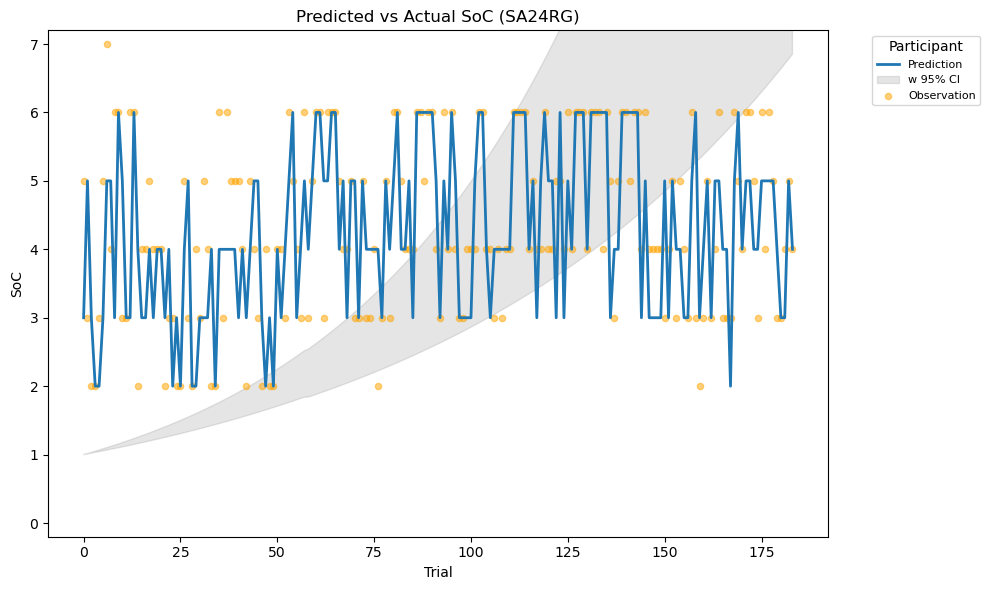

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


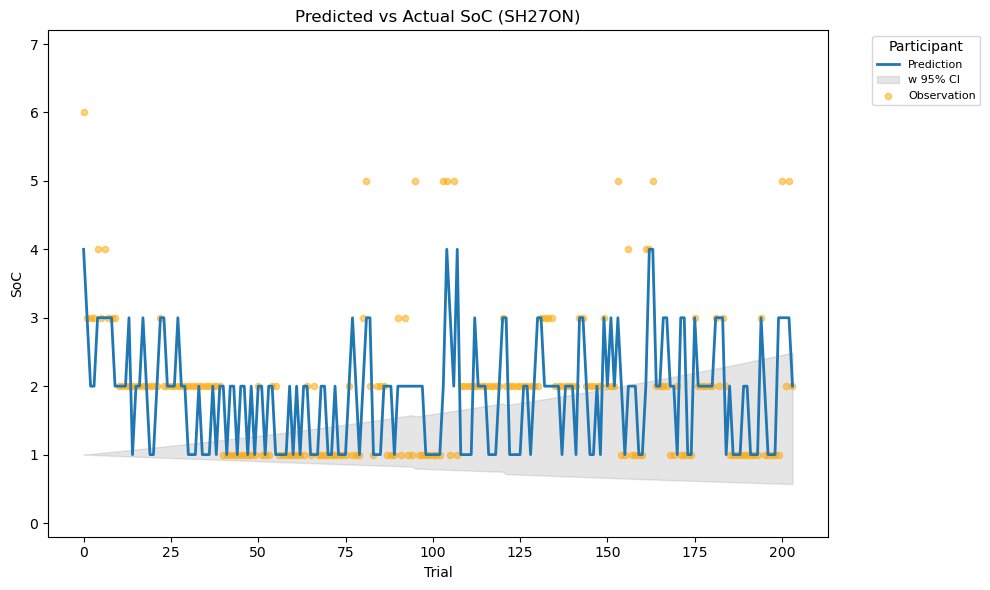

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


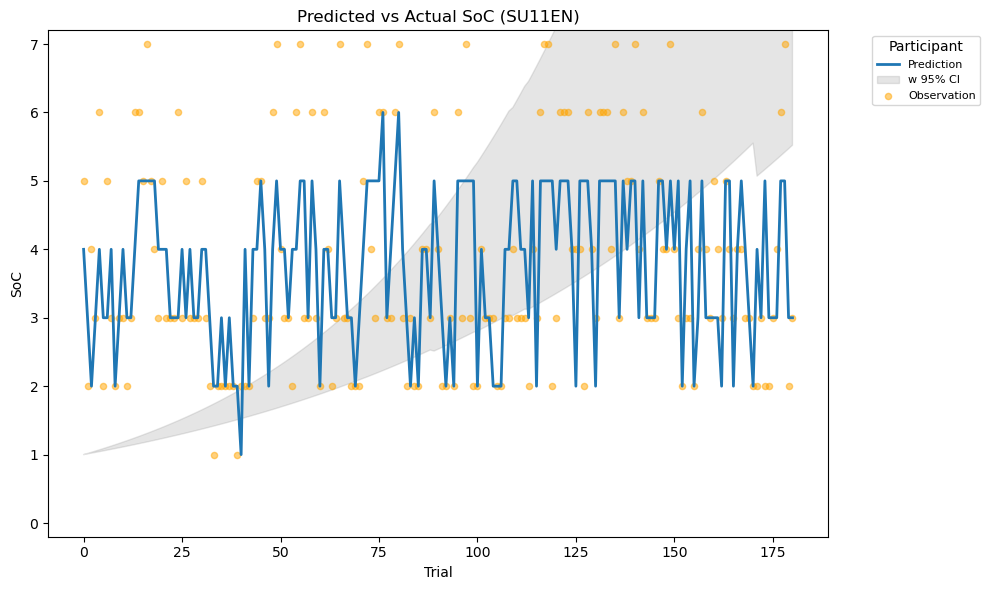

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


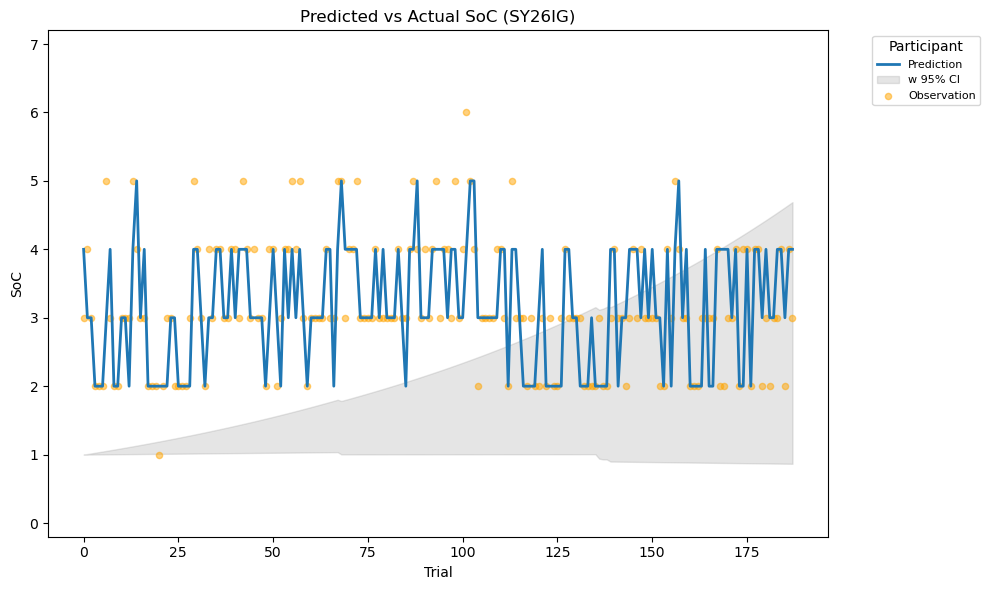

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


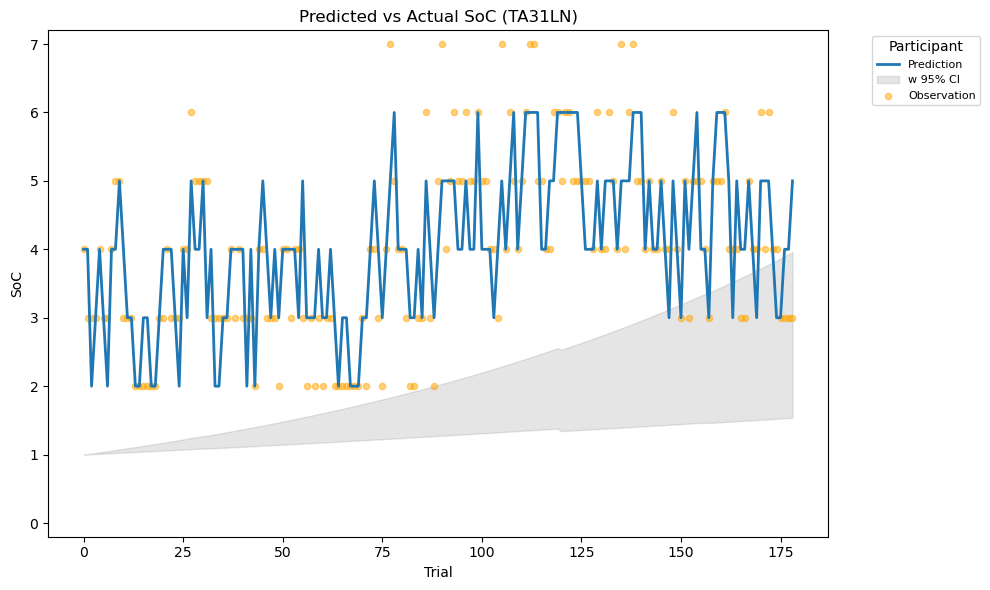

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# Get posterior samples of `w` as ndarray: (n_samples, n_total_trials)
w_samples_all = trace.get_values("w")  # shape (samples, n_trials)

for i in range(n_participants):
    plt.figure(figsize=(10, 6))

    # Select data for participant i
    df_i = df[df["ID_idx"] == i].sort_values("trial")
    trial_range = df_i["trial"].values
    SoC_obs = df_i["SoC"].values
    SoC_last = df_i["SoC_last_trial"].values
    N_crash_success = df_i["N_consecutive_crash_success"].values
    N_drift = df_i["N_drift"].values

    # Mask for this participant’s trials in the full posterior
    participant_mask = df["ID_idx"] == i
    w_samples = w_samples_all[:, participant_mask]  # shape (n_samples, n_trials_for_participant)

    # Mean and HDI for w
    w_mean = np.mean(w_samples, axis=0)
    w_hdi = az.hdi(w_samples, hdi_prob=0.95)

    # Get the corresponding alpha samples (shape: n_samples x 2) for this participant
    alpha_samples = trace.get_values("alpha")[:, i, :]  # shape (n_samples, 2)
    prior_samples = (
        alpha_samples[:, 0][:, None] * SoC_last[None, :] +
        alpha_samples[:, 1][:, None] * N_crash_success[None, :]
    )

    # Predict SoC using mean prior and mean w
    soc_pred = (prior_samples.mean(axis=0) + w_mean * N_drift) / (1 + w_mean)
    soc_pred_rounded = np.clip(np.round(soc_pred), 1, 7)

    # Plot predicted SoC
    plt.plot(trial_range, soc_pred_rounded, label="Prediction", lw=2)

    # Fill between 95% interval of w
    plt.fill_between(trial_range, w_hdi[:, 0], w_hdi[:, 1], color='gray', alpha=0.2, label="w 95% CI")

    # Plot observed SoC
    plt.scatter(trial_range, SoC_obs, s=20, alpha=0.5, color='orange', label="Observation")

    # Labels and legend
    plt.xlabel("Trial")
    plt.ylabel("SoC")
    plt.ylim([-0.2, 7.2])
    part_id = df_i["ID"].iloc[0]
    plt.title(f"Predicted vs Actual SoC ({part_id})")
    plt.legend(title="Participant", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()


As a metric to convey the accuracy of the predictions across participants we assess the *Root Mean Squared Error*

In [55]:

# get posterior samples of SoC_pred (shape: n_samples x n_trials)
soc_pred_samples = trace.get_values("SoC_pred")

# mean prediction per trial
soc_pred_mean = soc_pred_samples.mean(axis=0)

# round and clip predictions
soc_pred_rounded = np.clip(np.round(soc_pred_mean), 1, 7)
df["SoC_pred_rounded"] = soc_pred_rounded

# compute RMSE per ID
rmse_per_id = []

part_IDs = df["ID"].unique()

for part_ID in part_IDs:
    tmp_data = df[df["ID"] == part_ID]
    
    rmse = np.sqrt(np.mean((tmp_data["SoC_pred_rounded"] - tmp_data["SoC"]) ** 2))
    rmse_per_id.append(rmse)

# link rmse and ID
rmse_df = pd.DataFrame({
    "ID": part_IDs,
    "RMSE": rmse_per_id
})


In [56]:
rmse_df

,ID,RMSE
0,BI21RG,1.013870
1,SA24RG,1.055524
2,RO14IN,1.137593
3,TA31LN,0.842317
4,AN02EN,0.679674
5,NE25RG,1.054360
6,DI21EN,1.348597
7,SU11EN,1.198526
8,JS23RN,1.020728
9,NA16RG,1.231764


In [59]:
np.mean(rmse_df.RMSE), np.std(rmse_df.RMSE)

(0.9659486043364804, 0.22016808314252687)